In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

### Loading and preparing the data 

In [138]:
df = pd.read_csv("complete_crypto_data2.csv", index_col=0)
#df['daily_volatility'] = df['price'] - df['open']

df = df[df['crypto_name'] != 'ImmutableX']
df['return'] = round(df.groupby('crypto_name')['Price'].pct_change() * 100,3)
df['return'] = df['return'].fillna(0)
df = df[df['return'] < 600]

# Creating Dummy for fixed effects
df['crypto_dummy'] = df['crypto_name'].astype('category').cat.codes
df.shape  

# Add log attention 
df['log_attention'] = np.log(df['name_price_attention'])
df['log_attention'] = df['log_attention'].fillna(0)

# Add log returns
df['log_return'] = np.log(df['return'])
df['log_return'] = df['log_return'].fillna(0)

# Insert 0 for inf
df = df.replace([np.inf, -np.inf], 0)

/var/folders/hp/hkpqf03x0qdg7_8s3s9sy7gw0000gn/T/ipykernel_14393/148596706.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = round(df.groupby('crypto_name')['Price'].pct_change() * 100,3)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [139]:
df['crypto_dummy'] = df['crypto_name'].astype('category').cat.codes
df.head()

,Date,Price,Volume,Market_cap,crypto_name,name_price_attention,return,crypto_dummy,log_attention,log_return
0,2019-06-21,1.604939,6.653181e+05,0.000000e+00,Algorand,1.50,0.000,0,0.405465,0.000000
1,2019-06-22,3.172364,1.790331e+08,1.010855e+08,Algorand,0.00,97.663,0,0.000000,4.581523
2,2019-06-23,2.159165,2.588226e+08,7.665618e+07,Algorand,1.38,-31.938,0,0.322083,0.000000
3,2019-06-24,1.899598,2.100211e+08,6.647512e+07,Algorand,0.00,-12.022,0,0.000000,0.000000
4,2019-06-25,1.409310,1.574706e+08,5.522254e+07,Algorand,0.00,-25.810,0,0.000000,0.000000


In [132]:
from sklearn.preprocessing import StandardScaler

# Select columns to scale
columns_to_scale = ['Price', 'Volume', 'Market_cap', 'name_price_attention', 'return']

# Check for missing values
print(df[columns_to_scale].isnull().sum())

# Handle missing values if necessary
# df = df.dropna(subset=columns_to_scale)

# Initialize the scaler
scaler = StandardScaler()

# Create a copy of df
df_scaled = df.copy()

# Fit and transform the data
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Add log attention 
df_scaled['log_attention'] = np.log(df['name_price_attention'])
df_scaled['log_attention'] = df_scaled['log_attention'].fillna(0)

# Add log returns
df_scaled['log_return'] = np.log(df['return'])
df_scaled['log_return'] = df_scaled['log_return'].fillna(0)

# Insert 0 for inf
df_scaled = df_scaled.replace([np.inf, -np.inf], 0)

df_scaled.head()

Price                     68
Volume                   761
Market_cap              1685
name_price_attention       0
return                     0
dtype: int64


/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Price,Volume,Market_cap,crypto_name,name_price_attention,return,crypto_dummy,log_attention,log_return
0,2019-06-21,-0.180101,-0.269505,-0.235414,Algorand,-0.364255,-0.045227,0,0.405465,0.000000
1,2019-06-22,-0.179815,-0.240548,-0.234446,Algorand,-0.511961,11.153287,0,0.000000,4.581523
2,2019-06-23,-0.180000,-0.227594,-0.234680,Algorand,-0.376071,-3.707394,0,0.322083,0.000000
3,2019-06-24,-0.180048,-0.235517,-0.234777,Algorand,-0.511961,-1.423728,0,0.000000,0.000000
4,2019-06-25,-0.180137,-0.244048,-0.234885,Algorand,-0.511961,-3.004727,0,0.000000,0.000000


# Variable Visulaizations 

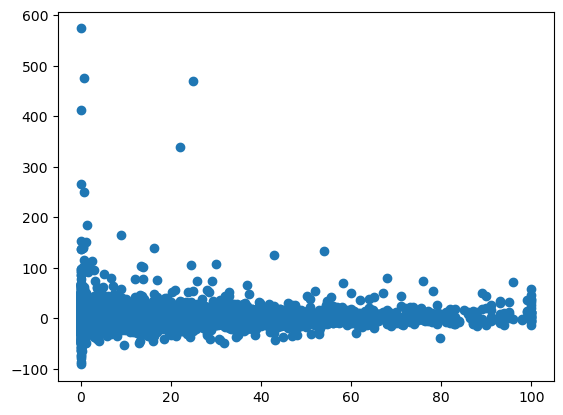

In [134]:
# plot dependent and independt variables with 

plt.scatter(df['name_price_attention'], df['return'])



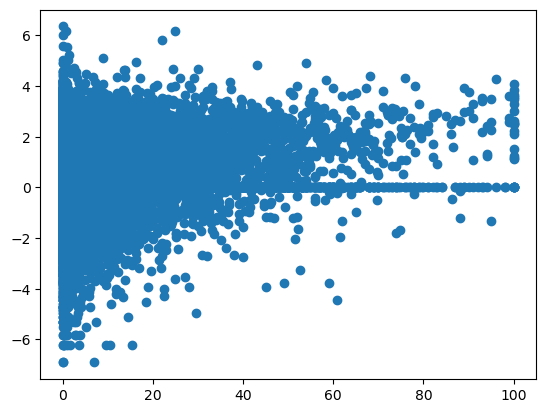

In [140]:
plt.scatter(df['name_price_attention'], df['log_return'])


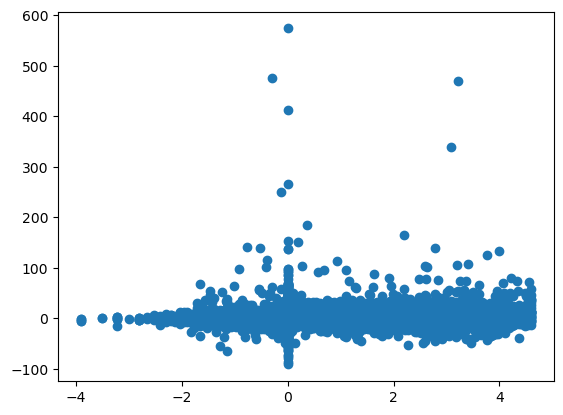

In [141]:
plt.scatter(df['log_attention'], df['return'])

# OLS Regression Models

In [166]:
from statsmodels.formula.api import ols

model_1 = ols('Q("return") ~  name_price_attention + C(crypto_dummy) + Market_cap + Volume' , data=df).fit() 

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.838
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.61e-31
Time:                        18:26:31   Log-Likelihood:                -71164.
No. Observations:               50427   AIC:                         1.424e+05
Df Residuals:                   50398   BIC:                         1.426e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0598      0.025     -2.429      0.015      -0.108      -0.012
C(crypto_dummy)[T.1]      0.3008      0.068      4.434      0.000       0.168       0.434
C(crypto_dummy)[T.2]      0.0236      0.038      0.627      0.530      -0.050       0.098
C(crypto_dummy)[T.3]      0.0826      0.032      2.562      0.010       0.019       0.146
C(crypto_dummy)[T.4]      0.0213      0.033      0.646      0.518      -0.043       0.086
C(crypto_dummy)[T.5]      0.0455      0.032      1.415      0.157      -0.018       0.109
C(crypto_dummy)[T.6]      0.0529      0.032      1.641      0.101      -0.010       0.116
C(crypto_dummy)[T.7]      0.0455      0.032      1.413      0.158      -0.018       0.109
C(crypto_dummy)[T.8]      0.0385      0.034      1.132      0.257      -0.028       0.105
C(crypto_dummy)[T.9]      0.0810      0.030      2.705      0.007       0.022       0.140
C(crypto_dummy)[T.10]     0.0732      0.031      2.339      0.019       0.012       0.134
C(crypto_dummy)[T.11]     0.0326      0.038      0.857      0.392      -0.042       0.107
C(crypto_dummy)[T.12]     0.0471      0.035      1.342      0.180      -0.022       0.116
C(crypto_dummy)[T.13]     0.0909      0.038      2.389      0.017       0.016       0.166
C(crypto_dummy)[T.14]     0.0459      0.030      1.535      0.125      -0.013       0.105
C(crypto_dummy)[T.15]     0.0624      0.038      1.640      0.101      -0.012       0.137
C(crypto_dummy)[T.16]     0.0100      0.037      0.267      0.789      -0.063       0.083
C(crypto_dummy)[T.17]     0.0841      0.034      2.450      0.014       0.017       0.151
C(crypto_dummy)[T.18]     0.0442      0.029      1.500      0.134      -0.014       0.102
C(crypto_dummy)[T.19]     0.2193      0.037      5.861      0.000       0.146       0.293
C(crypto_dummy)[T.20]     0.0595      0.036      1.636      0.102      -0.012       0.131
C(crypto_dummy)[T.21]     0.0444      0.035      1.260      0.208      -0.025       0.113
C(crypto_dummy)[T.22]     0.0849      0.030      2.836      0.005       0.026       0.144
C(crypto_dummy)[T.23]     0.0396      0.048      0.826      0.409      -0.054       0.134
C(crypto_dummy)[T.24]     0.0346      0.038      0.919      0.358      -0.039       0.108
C(crypto_dummy)[T.25]     0.0355      0.033      1.071      0.284      -0.029       0.100
name_price_attention      0.0500      0.005     10.494      0.000       0.041       0.059
Market_cap               -0.0358      0.007     -4.943      0.000      -0.050      -0.022
Volume                    0.0366      0.007      5.215      0.000       0.023       0.050
==============================================================================
Omnibus:                   107942.263   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarqu

Results indicate non-normal distribution of residuals and heteroskedasticity. However, the model may still useful for predictive purposes. According to the Central Limit Theorem, a sample of sufficient size will have a normal distribution. To further investigate the model, we will use the Breusch-Pagan test to determine if the residuals are homoskedastic.

In [173]:
# Breusch-Pagan test
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_1.resid, model_1.model.exog)

lzip(name, test)



[('Lagrange multiplier statistic', 190.83511904989987),
 ('p-value', 3.667486675813841e-26),
 ('f-value', 6.837496134983434),
 ('f p-value', 3.219131901977451e-26)]

The results of the Breusch-Pagan test indicate that the residuals are heteroskedastic. Thus, we will use the robust standard errors to correct for heteroskedasticity.

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant to the DataFrame for the intercept
df_vif = df[['name_price_attention', 'Market_cap', 'Volume']]

# Check for missing or infinite values and handle them
df_vif = df_vif.replace([np.inf, -np.inf], np.nan)
df_vif = df_vif.dropna()

df_vif = add_constant(df_vif)

# Calculate and print VIF
vif = pd.DataFrame()
vif["variables"] = df_vif.columns
vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)

              variables       VIF
0                 const  0.000000
1  name_price_attention  1.067324
2            Market_cap  2.382356
3                Volume  2.414583


/Users/alex/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF Values indicate no multicollinearity.

In [179]:
# Robust standard errors
model_1 = ols('Q("return") ~  name_price_attention + C(crypto_dummy) + Market_cap + Volume', data=df_scaled).fit() 
model_1_rob_errors = model_1.get_robustcov_results(cov_type='HC1')
model_1_rob_errors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.783
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.37e-06
Time:                        18:35:28   Log-Likelihood:                -71164.
No. Observations:               50427   AIC:                         1.424e+05
Df Residuals:                   50398   BIC:                         1.426e+05
Df Model:                          28                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0598      0.019     -3.158      0.002      -0.097      -0.023
C(crypto_dummy)[T.1]      0.3008      0.285      1.056      0.291      -0.257       0.859
C(crypto_dummy)[T.2]      0.0236      0.030      0.789      0.430      -0.035       0.082
C(crypto_dummy)[T.3]      0.0826      0.028      2.979      0.003       0.028       0.137
C(crypto_dummy)[T.4]      0.0213      0.022      0.956      0.339      -0.022       0.065
C(crypto_dummy)[T.5]      0.0455      0.027      1.695      0.090      -0.007       0.098
C(crypto_dummy)[T.6]      0.0529      0.025      2.108      0.035       0.004       0.102
C(crypto_dummy)[T.7]      0.0455      0.025      1.824      0.068      -0.003       0.094
C(crypto_dummy)[T.8]      0.0385      0.027      1.438      0.150      -0.014       0.091
C(crypto_dummy)[T.9]      0.0810      0.027      3.054      0.002       0.029       0.133
C(crypto_dummy)[T.10]     0.0732      0.026      2.769      0.006       0.021       0.125
C(crypto_dummy)[T.11]     0.0326      0.031      1.057      0.290      -0.028       0.093
C(crypto_dummy)[T.12]     0.0471      0.028      1.673      0.094      -0.008       0.102
C(crypto_dummy)[T.13]     0.0909      0.032      2.870      0.004       0.029       0.153
C(crypto_dummy)[T.14]     0.0459      0.022      2.079      0.038       0.003       0.089
C(crypto_dummy)[T.15]     0.0624      0.030      2.064      0.039       0.003       0.122
C(crypto_dummy)[T.16]     0.0100      0.027      0.371      0.711      -0.043       0.063
C(crypto_dummy)[T.17]     0.0841      0.029      2.896      0.004       0.027       0.141
C(crypto_dummy)[T.18]     0.0442      0.023      1.938      0.053      -0.001       0.089
C(crypto_dummy)[T.19]     0.2193      0.082      2.660      0.008       0.058       0.381
C(crypto_dummy)[T.20]     0.0595      0.029      2.021      0.043       0.002       0.117
C(crypto_dummy)[T.21]     0.0444      0.029      1.507      0.132      -0.013       0.102
C(crypto_dummy)[T.22]     0.0849      0.029      2.962      0.003       0.029       0.141
C(crypto_dummy)[T.23]     0.0396      0.054      0.737      0.461      -0.066       0.145
C(crypto_dummy)[T.24]     0.0346      0.029      1.174      0.240      -0.023       0.092
C(crypto_dummy)[T.25]     0.0355      0.024      1.453      0.146      -0.012       0.083
name_price_attention      0.0500      0.007      6.941      0.000       0.036       0.064
Market_cap               -0.0358      0.007     -4.983      0.000      -0.050      -0.022
Volume                    0.0366      0.010      3.744      0.000       0.017       0.056
==============================================================================
Omnibus:                   107942.263   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarqu

As a result, the OLS regression model is useful for predictive purposes. However, the model may not be useful for inferential purposes. Therefore, we tried log transformation of the dependent variable and the independent variables to see if it improves the model.

## Log Transformation of the Dependent Variable and the Independent Variables

In [178]:
# Log returns
model_1_log = ols('Q("log_return") ~  name_price_attention + C(crypto_dummy) +  Market_cap + Volume', data=df_scaled).fit() 

model_1_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     53.53
Date:                Wed, 06 Mar 2024   Prob (F-statistic):          4.92e-294
Time:                        18:34:54   Log-Likelihood:                -71483.
No. Observations:               50427   AIC:                         1.430e+05
Df Residuals:                   50398   BIC:                         1.433e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3943      0.025     15.923      0.000       0.346       0.443
C(crypto_dummy)[T.1]     -0.2703      0.068     -3.959      0.000      -0.404      -0.137
C(crypto_dummy)[T.2]      0.0368      0.038      0.971      0.331      -0.038       0.111
C(crypto_dummy)[T.3]     -0.0150      0.032     -0.463      0.643      -0.079       0.049
C(crypto_dummy)[T.4]     -0.3131      0.033     -9.436      0.000      -0.378      -0.248
C(crypto_dummy)[T.5]     -0.0107      0.032     -0.330      0.741      -0.074       0.053
C(crypto_dummy)[T.6]      0.0157      0.032      0.484      0.628      -0.048       0.079
C(crypto_dummy)[T.7]      0.1069      0.032      3.301      0.001       0.043       0.170
C(crypto_dummy)[T.8]      0.0764      0.034      2.235      0.025       0.009       0.143
C(crypto_dummy)[T.9]     -0.0505      0.030     -1.675      0.094      -0.110       0.009
C(crypto_dummy)[T.10]     0.0301      0.031      0.956      0.339      -0.032       0.092
C(crypto_dummy)[T.11]     0.0060      0.038      0.156      0.876      -0.069       0.081
C(crypto_dummy)[T.12]     0.0500      0.035      1.414      0.157      -0.019       0.119
C(crypto_dummy)[T.13]     0.2144      0.038      5.597      0.000       0.139       0.289
C(crypto_dummy)[T.14]    -0.0765      0.030     -2.542      0.011      -0.136      -0.018
C(crypto_dummy)[T.15]     0.1603      0.038      4.189      0.000       0.085       0.235
C(crypto_dummy)[T.16]    -0.0260      0.038     -0.691      0.490      -0.100       0.048
C(crypto_dummy)[T.17]     0.1529      0.035      4.427      0.000       0.085       0.221
C(crypto_dummy)[T.18]    -0.1420      0.030     -4.783      0.000      -0.200      -0.084
C(crypto_dummy)[T.19]     0.0901      0.038      2.392      0.017       0.016       0.164
C(crypto_dummy)[T.20]     0.1480      0.037      4.048      0.000       0.076       0.220
C(crypto_dummy)[T.21]     0.0817      0.035      2.303      0.021       0.012       0.151
C(crypto_dummy)[T.22]     0.0606      0.030      2.010      0.044       0.002       0.120
C(crypto_dummy)[T.23]    -0.0435      0.048     -0.902      0.367      -0.138       0.051
C(crypto_dummy)[T.24]     0.0568      0.038      1.498      0.134      -0.017       0.131
C(crypto_dummy)[T.25]     0.0569      0.033      1.706      0.088      -0.008       0.122
name_price_attention      0.1081      0.005     22.571      0.000       0.099       0.118
Market_cap               -0.0779      0.007    -10.679      0.000      -0.092      -0.064
Volume                    0.0968      0.007     13.708      0.000       0.083       0.111
==============================================================================
Omnibus:                     3929.485   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarqu

The transformation of the dependent variable did not improve model performance as the R-squared value decreased. Therefore, we transform the independent variable to log scale.

In [181]:
# Log returns
model_1_log = ols('Q("return") ~  log_attention + C(crypto_dummy) +  Market_cap + Volume ', data=df_scaled).fit() 

model_1_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.965
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.20e-16
Time:                        18:37:00   Log-Likelihood:                -71204.
No. Observations:               50427   AIC:                         1.425e+05
Df Residuals:                   50398   BIC:                         1.427e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0653      0.025     -2.580      0.010      -0.115      -0.016
C(crypto_dummy)[T.1]      0.2851      0.068      4.193      0.000       0.152       0.418
C(crypto_dummy)[T.2]      0.0281      0.038      0.745      0.456      -0.046       0.102
C(crypto_dummy)[T.3]      0.0664      0.032      2.053      0.040       0.003       0.130
C(crypto_dummy)[T.4]     -0.0008      0.033     -0.023      0.982      -0.066       0.064
C(crypto_dummy)[T.5]      0.0250      0.032      0.778      0.436      -0.038       0.088
C(crypto_dummy)[T.6]      0.0424      0.032      1.316      0.188      -0.021       0.106
C(crypto_dummy)[T.7]      0.0381      0.032      1.182      0.237      -0.025       0.101
C(crypto_dummy)[T.8]      0.0307      0.034      0.904      0.366      -0.036       0.097
C(crypto_dummy)[T.9]      0.0639      0.030      2.121      0.034       0.005       0.123
C(crypto_dummy)[T.10]     0.0575      0.032      1.825      0.068      -0.004       0.119
C(crypto_dummy)[T.11]     0.0146      0.038      0.385      0.700      -0.060       0.089
C(crypto_dummy)[T.12]     0.0350      0.035      0.992      0.321      -0.034       0.104
C(crypto_dummy)[T.13]     0.0801      0.038      2.099      0.036       0.005       0.155
C(crypto_dummy)[T.14]     0.0266      0.030      0.888      0.374      -0.032       0.085
C(crypto_dummy)[T.15]     0.0496      0.038      1.303      0.193      -0.025       0.124
C(crypto_dummy)[T.16]     0.0148      0.037      0.395      0.693      -0.059       0.088
C(crypto_dummy)[T.17]     0.0686      0.034      1.997      0.046       0.001       0.136
C(crypto_dummy)[T.18]     0.0275      0.029      0.933      0.351      -0.030       0.085
C(crypto_dummy)[T.19]     0.2010      0.037      5.378      0.000       0.128       0.274
C(crypto_dummy)[T.20]     0.0559      0.036      1.536      0.124      -0.015       0.127
C(crypto_dummy)[T.21]     0.0449      0.035      1.270      0.204      -0.024       0.114
C(crypto_dummy)[T.22]     0.0678      0.030      2.259      0.024       0.009       0.127
C(crypto_dummy)[T.23]     0.0181      0.048      0.377      0.706      -0.076       0.112
C(crypto_dummy)[T.24]     0.0247      0.038      0.656      0.512      -0.049       0.099
C(crypto_dummy)[T.25]     0.0227      0.033      0.685      0.494      -0.042       0.088
log_attention             0.0226      0.004      5.464      0.000       0.014       0.031
Market_cap               -0.0351      0.007     -4.817      0.000      -0.049      -0.021
Volume                    0.0416      0.007      5.910      0.000       0.028       0.055
==============================================================================
Omnibus:                   107926.960   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarqu

In [184]:
model_1_log = ols('Q("log_return") ~  log_attention + C(crypto_dummy) +  Market_cap + Volume', data=df_scaled).fit() 

model_1_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     48.96
Date:                Wed, 06 Mar 2024   Prob (F-statistic):          1.73e-267
Time:                        18:37:58   Log-Likelihood:                -71546.
No. Observations:               50427   AIC:                         1.431e+05
Df Residuals:                   50398   BIC:                         1.434e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3305      0.025     12.964      0.000       0.281       0.380
C(crypto_dummy)[T.1]     -0.2613      0.068     -3.818      0.000      -0.395      -0.127
C(crypto_dummy)[T.2]      0.0367      0.038      0.968      0.333      -0.038       0.111
C(crypto_dummy)[T.3]     -0.0170      0.033     -0.523      0.601      -0.081       0.047
C(crypto_dummy)[T.4]     -0.3195      0.033     -9.600      0.000      -0.385      -0.254
C(crypto_dummy)[T.5]     -0.0254      0.032     -0.784      0.433      -0.089       0.038
C(crypto_dummy)[T.6]      0.0161      0.032      0.497      0.619      -0.048       0.080
C(crypto_dummy)[T.7]      0.0947      0.032      2.920      0.003       0.031       0.158
C(crypto_dummy)[T.8]      0.0686      0.034      2.004      0.045       0.002       0.136
C(crypto_dummy)[T.9]     -0.0453      0.030     -1.495      0.135      -0.105       0.014
C(crypto_dummy)[T.10]     0.0415      0.032      1.309      0.190      -0.021       0.104
C(crypto_dummy)[T.11]    -0.0116      0.038     -0.303      0.762      -0.087       0.063
C(crypto_dummy)[T.12]     0.0541      0.035      1.525      0.127      -0.015       0.124
C(crypto_dummy)[T.13]     0.2208      0.038      5.747      0.000       0.145       0.296
C(crypto_dummy)[T.14]    -0.0848      0.030     -2.812      0.005      -0.144      -0.026
C(crypto_dummy)[T.15]     0.1644      0.038      4.283      0.000       0.089       0.240
C(crypto_dummy)[T.16]    -0.0199      0.038     -0.527      0.598      -0.094       0.054
C(crypto_dummy)[T.17]     0.1368      0.035      3.958      0.000       0.069       0.205
C(crypto_dummy)[T.18]    -0.1673      0.030     -5.640      0.000      -0.225      -0.109
C(crypto_dummy)[T.19]     0.0581      0.038      1.545      0.122      -0.016       0.132
C(crypto_dummy)[T.20]     0.1398      0.037      3.818      0.000       0.068       0.212
C(crypto_dummy)[T.21]     0.1022      0.036      2.874      0.004       0.033       0.172
C(crypto_dummy)[T.22]     0.0548      0.030      1.814      0.070      -0.004       0.114
C(crypto_dummy)[T.23]    -0.0650      0.048     -1.347      0.178      -0.160       0.030
C(crypto_dummy)[T.24]     0.0412      0.038      1.087      0.277      -0.033       0.116
C(crypto_dummy)[T.25]     0.0460      0.033      1.379      0.168      -0.019       0.111
log_attention             0.0816      0.004     19.592      0.000       0.073       0.090
Market_cap               -0.0833      0.007    -11.358      0.000      -0.098      -0.069
Volume                    0.0979      0.007     13.817      0.000       0.084       0.112
==============================================================================
Omnibus:                     3955.205   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarqu

In [183]:
model_1_log = ols('Q("log_return") ~  log_attention + C(crypto_dummy) +  Market_cap + Volume', data=df_scaled).fit() 
model_1_log_rob_errors = model_1_log.get_robustcov_results(cov_type='HC1')
model_1_log_rob_errors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     45.68
Date:                Wed, 06 Mar 2024   Prob (F-statistic):          1.79e-248
Time:                        18:37:45   Log-Likelihood:                -71546.
No. Observations:               50427   AIC:                         1.431e+05
Df Residuals:                   50398   BIC:                         1.434e+05
Df Model:                          28                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3305      0.025     13.129      0.000       0.281       0.380
C(crypto_dummy)[T.1]     -0.2613      0.048     -5.492      0.000      -0.355      -0.168
C(crypto_dummy)[T.2]      0.0367      0.038      0.977      0.328      -0.037       0.110
C(crypto_dummy)[T.3]     -0.0170      0.033     -0.519      0.604      -0.081       0.047
C(crypto_dummy)[T.4]     -0.3195      0.033     -9.735      0.000      -0.384      -0.255
C(crypto_dummy)[T.5]     -0.0254      0.032     -0.800      0.424      -0.088       0.037
C(crypto_dummy)[T.6]      0.0161      0.032      0.502      0.616      -0.047       0.079
C(crypto_dummy)[T.7]      0.0947      0.033      2.906      0.004       0.031       0.159
C(crypto_dummy)[T.8]      0.0686      0.034      2.008      0.045       0.002       0.135
C(crypto_dummy)[T.9]     -0.0453      0.031     -1.481      0.139      -0.105       0.015
C(crypto_dummy)[T.10]     0.0415      0.031      1.328      0.184      -0.020       0.103
C(crypto_dummy)[T.11]    -0.0116      0.038     -0.309      0.757      -0.085       0.062
C(crypto_dummy)[T.12]     0.0541      0.035      1.549      0.121      -0.014       0.123
C(crypto_dummy)[T.13]     0.2208      0.040      5.486      0.000       0.142       0.300
C(crypto_dummy)[T.14]    -0.0848      0.030     -2.864      0.004      -0.143      -0.027
C(crypto_dummy)[T.15]     0.1644      0.039      4.210      0.000       0.088       0.241
C(crypto_dummy)[T.16]    -0.0199      0.036     -0.553      0.581      -0.090       0.051
C(crypto_dummy)[T.17]     0.1368      0.035      3.909      0.000       0.068       0.205
C(crypto_dummy)[T.18]    -0.1673      0.029     -5.744      0.000      -0.224      -0.110
C(crypto_dummy)[T.19]     0.0581      0.040      1.467      0.142      -0.020       0.136
C(crypto_dummy)[T.20]     0.1398      0.037      3.740      0.000       0.067       0.213
C(crypto_dummy)[T.21]     0.1022      0.036      2.832      0.005       0.031       0.173
C(crypto_dummy)[T.22]     0.0548      0.030      1.831      0.067      -0.004       0.113
C(crypto_dummy)[T.23]    -0.0650      0.049     -1.319      0.187      -0.162       0.032
C(crypto_dummy)[T.24]     0.0412      0.037      1.110      0.267      -0.032       0.114
C(crypto_dummy)[T.25]     0.0460      0.032      1.430      0.153      -0.017       0.109
log_attention             0.0816      0.005     18.059      0.000       0.073       0.090
Market_cap               -0.0833      0.007    -11.238      0.000      -0.098      -0.069
Volume                    0.0979      0.008     12.141      0.000       0.082       0.114
==============================================================================
Omnibus:                     3955.205   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarqu

# Robust Regression with hubert T norm

In [185]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the formula
formula = 'Q("return") ~ C(crypto_dummy) + name_price_attention + Market_cap + Volume'

# Fit the model using RLM for a robust regression
model = smf.rlm(formula, data=df_scaled, M=sm.robust.norms.HuberT())
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:            Q("return")   No. Observations:                50427
Model:                            RLM   Df Residuals:                    50398
Method:                          IRLS   Df Model:                           28
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        18:38:32                                         
No. Iterations:                    26                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0567      0.013     -4.529      0.000      -0.081      -0.032
C(crypto_dummy)[T.1]      0.0197      0.035      0.572      0.568      -0.048       0.087
C(crypto_dummy)[T.2]      0.0072      0.019      0.378      0.706      -0.030       0.045
C(crypto_dummy)[T.3]      0.0418      0.016      2.546      0.011       0.010       0.074
C(crypto_dummy)[T.4]      0.0316      0.017      1.881      0.060      -0.001       0.064
C(crypto_dummy)[T.5]      0.0098      0.016      0.598      0.550      -0.022       0.042
C(crypto_dummy)[T.6]      0.0142      0.016      0.869      0.385      -0.018       0.046
C(crypto_dummy)[T.7]      0.0209      0.016      1.276      0.202      -0.011       0.053
C(crypto_dummy)[T.8]      0.0155      0.017      0.895      0.371      -0.018       0.049
C(crypto_dummy)[T.9]      0.0063      0.015      0.414      0.679      -0.024       0.036
C(crypto_dummy)[T.10]     0.0204      0.016      1.281      0.200      -0.011       0.052
C(crypto_dummy)[T.11]    -0.0021      0.019     -0.109      0.913      -0.040       0.036
C(crypto_dummy)[T.12]     0.0102      0.018      0.571      0.568      -0.025       0.045
C(crypto_dummy)[T.13]     0.0266      0.019      1.372      0.170      -0.011       0.065
C(crypto_dummy)[T.14]     0.0203      0.015      1.331      0.183      -0.010       0.050
C(crypto_dummy)[T.15]     0.0202      0.019      1.044      0.297      -0.018       0.058
C(crypto_dummy)[T.16]     0.0041      0.019      0.213      0.831      -0.033       0.041
C(crypto_dummy)[T.17]     0.0211      0.017      1.209      0.227      -0.013       0.055
C(crypto_dummy)[T.18]     0.0046      0.015      0.307      0.759      -0.025       0.034
C(crypto_dummy)[T.19]    -0.0110      0.019     -0.578      0.563      -0.048       0.026
C(crypto_dummy)[T.20]     0.0217      0.018      1.173      0.241      -0.015       0.058
C(crypto_dummy)[T.21]     0.0092      0.018      0.515      0.607      -0.026       0.044
C(crypto_dummy)[T.22]     0.0090      0.015      0.588      0.556      -0.021       0.039
C(crypto_dummy)[T.23]    -0.0169      0.024     -0.694      0.487      -0.065       0.031
C(crypto_dummy)[T.24]     0.0096      0.019      0.499      0.617      -0.028       0.047
C(crypto_dummy)[T.25]     0.0193      0.017      1.148      0.251      -0.014       0.052
name_price_attention      0.0220      0.002      9.075      0.000       0.017       0.027
Market_cap               -0.0102      0.004     -2.766      0.006      -0.017      -0.003
Volume                    0.0090      0.004      2.514      0.012       0.002       0.016
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might no

# Robust Regression to deal with outliers

In [186]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the formula
formula = 'Q("log_return") ~ C(crypto_dummy) + log_attention'

# Fit the model using RLM for a robust regression
model = smf.rlm(formula, data=df, M=sm.robust.norms.HuberT())
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        Q("log_return")   No. Observations:                52440
Model:                            RLM   Df Residuals:                    52413
Method:                          IRLS   Df Model:                           26
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        18:39:31                                         
No. Iterations:                    37                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2291      0.017     13.630      0.000       0.196       0.262
C(crypto_dummy)[T.1]     -0.2328      0.038     -6.086      0.000      -0.308      -0.158
C(crypto_dummy)[T.2]      0.0007      0.025      0.028      0.978      -0.049       0.050
C(crypto_dummy)[T.3]     -0.0121      0.021     -0.561      0.575      -0.054       0.030
C(crypto_dummy)[T.4]     -0.1443      0.019     -7.410      0.000      -0.182      -0.106
C(crypto_dummy)[T.5]     -0.0155      0.021     -0.721      0.471      -0.058       0.027
C(crypto_dummy)[T.6]     -0.0015      0.022     -0.071      0.943      -0.044       0.041
C(crypto_dummy)[T.7]      0.0599      0.021      2.786      0.005       0.018       0.102
C(crypto_dummy)[T.8]      0.0337      0.023      1.479      0.139      -0.011       0.078
C(crypto_dummy)[T.9]     -0.0456      0.020     -2.262      0.024      -0.085      -0.006
C(crypto_dummy)[T.10]     0.0062      0.021      0.293      0.769      -0.035       0.047
C(crypto_dummy)[T.11]     0.0583      0.022      2.671      0.008       0.016       0.101
C(crypto_dummy)[T.12]     0.0263      0.024      1.113      0.266      -0.020       0.073
C(crypto_dummy)[T.13]     0.0932      0.026      3.644      0.000       0.043       0.143
C(crypto_dummy)[T.14]    -0.0512      0.020     -2.554      0.011      -0.090      -0.012
C(crypto_dummy)[T.15]     0.0744      0.026      2.912      0.004       0.024       0.124
C(crypto_dummy)[T.16]    -0.0061      0.025     -0.242      0.809      -0.055       0.043
C(crypto_dummy)[T.17]     0.0660      0.023      2.866      0.004       0.021       0.111
C(crypto_dummy)[T.18]    -0.1260      0.019     -6.466      0.000      -0.164      -0.088
C(crypto_dummy)[T.19]    -0.0304      0.025     -1.215      0.225      -0.079       0.019
C(crypto_dummy)[T.20]     0.0577      0.024      2.367      0.018       0.010       0.106
C(crypto_dummy)[T.21]     0.0452      0.024      1.908      0.056      -0.001       0.092
C(crypto_dummy)[T.22]     0.0053      0.020      0.264      0.792      -0.034       0.045
C(crypto_dummy)[T.23]    -0.0461      0.032     -1.435      0.151      -0.109       0.017
C(crypto_dummy)[T.24]     0.0276      0.025      1.092      0.275      -0.022       0.077
C(crypto_dummy)[T.25]     0.0166      0.022      0.748      0.454      -0.027       0.060
log_attention             0.0468      0.003     18.229      0.000       0.042       0.052
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

# Robustness Tests

In [154]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the formula
formula = 'Q("log_return") ~ C(crypto_dummy) + log_attention'

# Fit the model using RLM for a robust regression
model = smf.rlm(formula, data=df, M=sm.robust.norms.HuberT())
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        Q("log_return")   No. Observations:                52440
Model:                            RLM   Df Residuals:                    52413
Method:                          IRLS   Df Model:                           26
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        18:17:41                                         
No. Iterations:                    37                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2291      0.017     13.630      0.000       0.196       0.262
C(crypto_dummy)[T.1]     -0.2328      0.038     -6.086      0.000      -0.308      -0.158
C(crypto_dummy)[T.2]      0.0007      0.025      0.028      0.978      -0.049       0.050
C(crypto_dummy)[T.3]     -0.0121      0.021     -0.561      0.575      -0.054       0.030
C(crypto_dummy)[T.4]     -0.1443      0.019     -7.410      0.000      -0.182      -0.106
C(crypto_dummy)[T.5]     -0.0155      0.021     -0.721      0.471      -0.058       0.027
C(crypto_dummy)[T.6]     -0.0015      0.022     -0.071      0.943      -0.044       0.041
C(crypto_dummy)[T.7]      0.0599      0.021      2.786      0.005       0.018       0.102
C(crypto_dummy)[T.8]      0.0337      0.023      1.479      0.139      -0.011       0.078
C(crypto_dummy)[T.9]     -0.0456      0.020     -2.262      0.024      -0.085      -0.006
C(crypto_dummy)[T.10]     0.0062      0.021      0.293      0.769      -0.035       0.047
C(crypto_dummy)[T.11]     0.0583      0.022      2.671      0.008       0.016       0.101
C(crypto_dummy)[T.12]     0.0263      0.024      1.113      0.266      -0.020       0.073
C(crypto_dummy)[T.13]     0.0932      0.026      3.644      0.000       0.043       0.143
C(crypto_dummy)[T.14]    -0.0512      0.020     -2.554      0.011      -0.090      -0.012
C(crypto_dummy)[T.15]     0.0744      0.026      2.912      0.004       0.024       0.124
C(crypto_dummy)[T.16]    -0.0061      0.025     -0.242      0.809      -0.055       0.043
C(crypto_dummy)[T.17]     0.0660      0.023      2.866      0.004       0.021       0.111
C(crypto_dummy)[T.18]    -0.1260      0.019     -6.466      0.000      -0.164      -0.088
C(crypto_dummy)[T.19]    -0.0304      0.025     -1.215      0.225      -0.079       0.019
C(crypto_dummy)[T.20]     0.0577      0.024      2.367      0.018       0.010       0.106
C(crypto_dummy)[T.21]     0.0452      0.024      1.908      0.056      -0.001       0.092
C(crypto_dummy)[T.22]     0.0053      0.020      0.264      0.792      -0.034       0.045
C(crypto_dummy)[T.23]    -0.0461      0.032     -1.435      0.151      -0.109       0.017
C(crypto_dummy)[T.24]     0.0276      0.025      1.092      0.275      -0.022       0.077
C(crypto_dummy)[T.25]     0.0166      0.022      0.748      0.454      -0.027       0.060
log_attention             0.0468      0.003     18.229      0.000       0.042       0.052
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

# Start with OLS and robust Regression (inspecting the relationships)

## Model Overview
fix_seed = 42

- y = df['return']
- X = df[['name_price_attention']]
- X2 = df[['name_price_attention', 'mkt_cap']]
- X3 = df[['name_price_attention', 'daily_volatility']]
- X4 = df[['name_price_attention', 'volume']]
- X5 = df[['name_price_attention', 'mkt_cap']]
- X6 = df[['name_price_attention', 'mkt_cap']]
- X7 = df[['name_price_attention', 'mkt_cap']]
- X8 = df[['name_price_attention', 'mkt_cap']]
- X9 = df[['name_price_attention', 'mkt_cap']]
- X10 = df[['name_price_attention', 'mkt_cap']]
- X11 =  df[['name_price_attention', 'mkt_cap']]

# Model 1: Return ~ Name_Price_Attention

## OLS Regression, no transformation

In [47]:
from statsmodels.formula.api import rlm

# Fit the robust model
robust_model_1 = rlm('Q("return") ~ name_price_attention + C(crypto_dummy)', data=df, M=sm.robust.norms.HuberT()).fit()
predictions = robust_model_1.predict()
# Print the summary
robust_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:            Q("return")   No. Observations:                52892
Model:                            RLM   Df Residuals:                    52864
Method:                          IRLS   Df Model:                           27
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        16:24:18                                         
No. Iterations:                    26                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1745      0.110     -1.582      0.114      -0.391       0.042
C(crypto_dummy)[T.1]      0.1297      0.252      0.514      0.607      -0.365       0.625
C(crypto_dummy)[T.2]      0.0669      0.167      0.400      0.689      -0.261       0.395
C(crypto_dummy)[T.3]      0.3574      0.142      2.517      0.012       0.079       0.636
C(crypto_dummy)[T.4]      0.3241      0.129      2.515      0.012       0.071       0.577
C(crypto_dummy)[T.5]      0.0776      0.142      0.546      0.585      -0.201       0.356
C(crypto_dummy)[T.6]      0.1109      0.143      0.778      0.437      -0.169       0.390
C(crypto_dummy)[T.7]      0.1749      0.142      1.230      0.219      -0.104       0.454
C(crypto_dummy)[T.8]      0.1290      0.151      0.855      0.392      -0.167       0.425
C(crypto_dummy)[T.9]      0.0341      0.133      0.257      0.797      -0.226       0.294
C(crypto_dummy)[T.10]     0.1632      0.139      1.177      0.239      -0.109       0.435
C(crypto_dummy)[T.11]     0.0361      0.144      0.250      0.803      -0.247       0.319
C(crypto_dummy)[T.12]     0.0714      0.156      0.458      0.647      -0.234       0.377
C(crypto_dummy)[T.13]    -0.9097      0.251     -3.618      0.000      -1.403      -0.417
C(crypto_dummy)[T.14]     0.2143      0.169      1.268      0.205      -0.117       0.546
C(crypto_dummy)[T.15]     0.1703      0.133      1.285      0.199      -0.089       0.430
C(crypto_dummy)[T.16]     0.1607      0.169      0.952      0.341      -0.170       0.492
C(crypto_dummy)[T.17]     0.0333      0.166      0.200      0.841      -0.292       0.359
C(crypto_dummy)[T.18]     0.1712      0.152      1.123      0.261      -0.128       0.470
C(crypto_dummy)[T.19]     0.0491      0.129      0.380      0.704      -0.204       0.302
C(crypto_dummy)[T.20]    -0.0967      0.166     -0.584      0.559      -0.421       0.228
C(crypto_dummy)[T.21]     0.1883      0.161      1.167      0.243      -0.128       0.505
C(crypto_dummy)[T.22]     0.0748      0.157      0.478      0.633      -0.232       0.382
C(crypto_dummy)[T.23]     0.0598      0.133      0.450      0.653      -0.201       0.320
C(crypto_dummy)[T.24]    -0.1650      0.213     -0.775      0.438      -0.582       0.252
C(crypto_dummy)[T.25]     0.0765      0.167      0.458      0.647      -0.251       0.404
C(crypto_dummy)[T.26]     0.1568      0.147      1.066      0.286      -0.132       0.445
name_price_attention      0.0162      0.002      8.286      0.000       0.012       0.020
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

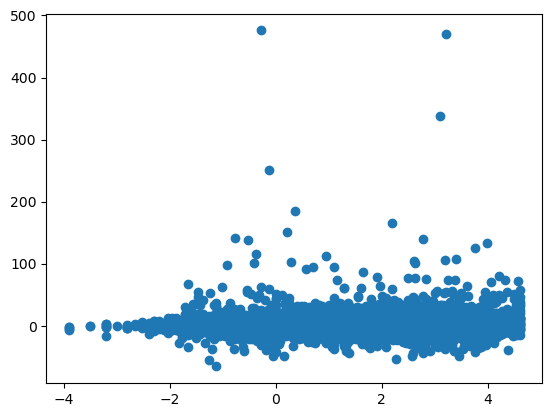

In [123]:
#plt.scatter(df['name_price_attention'], df['return'])
df['log_return'] = np.log(df['return'])
df['log_attention'] = np.log(df['name_price_attention'])
#plt.scatter(df['name_price_attention'], df['log_return'])
plt.scatter(df['log_attention'], df['return'])

In [39]:
mse = mean_squared_error(df['return'], predictions)

print("Mean Squared Error (MSE) for the OLS model:", mse)

Mean Squared Error (MSE) for the OLS model: 9423.166421130594


In [ ]:
ols_mse = mean_squared_error(y_test, ols_predictions)
huber_mse = mean_squared_error(y_test, huber_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)

In [41]:
# Unscaled data
from statsmodels.formula.api import ols

model_1 = ols('Q("return") ~  name_price_attention + C(crypto_dummy)', data=df).fit() 
prediction_1 = model_1.predict()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.616
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.79e-14
Time:                        13:59:36   Log-Likelihood:            -3.1699e+05
No. Observations:               52892   AIC:                         6.340e+05
Df Residuals:                   52864   BIC:                         6.343e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9949      2.427      0.410      0.682      -3.761       5.751
C(crypto_dummy)[T.1]      2.1099      5.553      0.380      0.704      -8.773      12.993
C(crypto_dummy)[T.2]      0.5159      3.682      0.140      0.889      -6.701       7.733
C(crypto_dummy)[T.3]      0.9151      3.123      0.293      0.770      -5.206       7.037
C(crypto_dummy)[T.4]     -0.0416      2.835     -0.015      0.988      -5.599       5.515
C(crypto_dummy)[T.5]     -0.5128      3.128     -0.164      0.870      -6.645       5.619
C(crypto_dummy)[T.6]     -0.1827      3.136     -0.058      0.954      -6.329       5.964
C(crypto_dummy)[T.7]      0.1673      3.129      0.053      0.957      -5.966       6.300
C(crypto_dummy)[T.8]     -0.0120      3.317     -0.004      0.997      -6.514       6.490
C(crypto_dummy)[T.9]     -0.4558      2.921     -0.156      0.876      -6.180       5.269
C(crypto_dummy)[T.10]    -0.5208      3.050     -0.171      0.864      -6.499       5.458
C(crypto_dummy)[T.11]    -0.4116      3.173     -0.130      0.897      -6.630       5.807
C(crypto_dummy)[T.12]    -0.4692      3.431     -0.137      0.891      -7.195       6.256
C(crypto_dummy)[T.13]    54.3416      5.530      9.826      0.000      43.502      65.181
C(crypto_dummy)[T.14]    -0.0413      3.717     -0.011      0.991      -7.327       7.245
C(crypto_dummy)[T.15]    -0.5913      2.915     -0.203      0.839      -6.304       5.121
C(crypto_dummy)[T.16]    -0.3574      3.713     -0.096      0.923      -7.634       6.920
C(crypto_dummy)[T.17]     0.3291      3.652      0.090      0.928      -6.828       7.487
C(crypto_dummy)[T.18]     0.0383      3.352      0.011      0.991      -6.532       6.609
C(crypto_dummy)[T.19]    -0.1981      2.840     -0.070      0.944      -5.765       5.369
C(crypto_dummy)[T.20]     4.0694      3.641      1.118      0.264      -3.067      11.206
C(crypto_dummy)[T.21]     0.4940      3.549      0.139      0.889      -6.463       7.451
C(crypto_dummy)[T.22]     0.0337      3.443      0.010      0.992      -6.714       6.781
C(crypto_dummy)[T.23]    -0.2701      2.922     -0.092      0.926      -5.996       5.456
C(crypto_dummy)[T.24]    -0.6759      4.683     -0.144      0.885      -9.855       8.503
C(crypto_dummy)[T.25]    -0.0523      3.678     -0.014      0.989      -7.261       7.156
C(crypto_dummy)[T.26]    -0.3199      3.235     -0.099      0.921      -6.661       6.021
name_price_attention     -0.0856      0.043     -1.989      0.047      -0.170      -0.001
==============================================================================
Omnibus:                   264036.234   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5065301169657.728
Skew:                         214.708   Prob(JB):       

In [42]:
mse1 = mean_squared_error(df['return'], prediction_1)

print("Mean Squared Error (MSE) for the OLS model:", mse1)

Mean Squared Error (MSE) for the OLS model: 9399.678109924107


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals vs Fitted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(model_1.fittedvalues, model_1.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Normal Q-Q plot for checking normality of residuals
plt.figure(figsize=(8,6))
stats.probplot(model_1.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# Scale-Location plot for checking homoscedasticity
plt.figure(figsize=(8,6))
plt.scatter(model_1.fittedvalues, model_1.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot for checking influential cases
#fig, ax = plt.subplots(figsize=(8,6))
#fig = sm.graphics.influence_plot(model_1, ax=ax, criterion="cooks")
#plt.title('Influence Plot')
#plt.show()

# Observed vs Predicted plot for checking linearity
#plt.figure(figsize=(8,6))
#plt.scatter(model_1.fittedvalues, y_train)
#plt.plot(y_train, y_train, color='red')
#plt.xlabel('Predicted values')
#plt.ylabel('Observed values')
#plt.title('Observed vs Predicted')
#plt.show()

In [43]:
# Scaled Model
from statsmodels.formula.api import ols

model_scaled = ols('Q("return") ~  name_price_attention + C(crypto_dummy)', data=df_scaled).fit() 
predict_scaled = model_scaled.predict()
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.523
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           7.97e-19
Time:                        14:00:58   Log-Likelihood:            -3.0539e+05
No. Observations:               50789   AIC:                         6.108e+05
Df Residuals:                   50761   BIC:                         6.111e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9954      2.476      0.402      0.688      -3.858       5.848
C(crypto_dummy)[T.1]      3.8408      6.748      0.569      0.569      -9.386      17.068
C(crypto_dummy)[T.2]      0.5160      3.756      0.137      0.891      -6.845       7.877
C(crypto_dummy)[T.3]      0.8288      3.207      0.258      0.796      -5.456       7.114
C(crypto_dummy)[T.4]     -0.1009      2.929     -0.034      0.973      -5.842       5.640
C(crypto_dummy)[T.5]     -0.5025      3.194     -0.157      0.875      -6.763       5.758
C(crypto_dummy)[T.6]     -0.1739      3.206     -0.054      0.957      -6.458       6.110
C(crypto_dummy)[T.7]      0.1730      3.206      0.054      0.957      -6.111       6.457
C(crypto_dummy)[T.8]     -0.0122      3.384     -0.004      0.997      -6.644       6.620
C(crypto_dummy)[T.9]     -0.4681      2.980     -0.157      0.875      -6.309       5.372
C(crypto_dummy)[T.10]    -0.5212      3.112     -0.167      0.867      -6.620       5.578
C(crypto_dummy)[T.11]    -0.5461      3.787     -0.144      0.885      -7.968       6.876
C(crypto_dummy)[T.12]    -0.4695      3.500     -0.134      0.893      -7.330       6.391
C(crypto_dummy)[T.13]    66.9578      6.109     10.960      0.000      54.983      78.932
C(crypto_dummy)[T.14]    -0.0416      3.792     -0.011      0.991      -7.474       7.391
C(crypto_dummy)[T.15]    -0.5951      2.974     -0.200      0.841      -6.424       5.233
C(crypto_dummy)[T.16]    -0.3578      3.787     -0.094      0.925      -7.781       7.065
C(crypto_dummy)[T.17]     0.3292      3.725      0.088      0.930      -6.972       7.630
C(crypto_dummy)[T.18]     0.0380      3.420      0.011      0.991      -6.664       6.740
C(crypto_dummy)[T.19]    -0.1262      2.933     -0.043      0.966      -5.875       5.623
C(crypto_dummy)[T.20]     4.1267      3.726      1.108      0.268      -3.176      11.429
C(crypto_dummy)[T.21]     0.4939      3.620      0.136      0.891      -6.602       7.590
C(crypto_dummy)[T.22]     0.0336      3.511      0.010      0.992      -6.849       6.916
C(crypto_dummy)[T.23]    -0.2692      2.981     -0.090      0.928      -6.112       5.574
C(crypto_dummy)[T.24]    -0.6763      4.777     -0.142      0.887     -10.039       8.687
C(crypto_dummy)[T.25]    -0.0525      3.752     -0.014      0.989      -7.406       7.301
C(crypto_dummy)[T.26]    -0.3201      3.300     -0.097      0.923      -6.789       6.148
name_price_attention     -0.0857      0.044     -1.932      0.053      -0.173       0.001
==============================================================================
Omnibus:                   252066.164   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    4481496457906.785
Skew:                         210.339   Prob(JB):       

In [46]:
mse_scaled = mean_squared_error(df_scaled['return'], predict_scaled)
print("Mean Squared Error (MSE) for the OLS model:", mse_scaled)

Mean Squared Error (MSE) for the OLS model: 9779.348214257989


Based on the regression output provided, here are a few observations and potential actions to consider:

Extremely High Skewness and Kurtosis: These statistics suggest that the distribution of the residuals is very far from normal, which could significantly impact the reliability of the regression results. This could be due to outliers or a non-linear relationship that hasn't been accounted for.

Omnibus and Jarque-Bera Tests: Both of these tests provide evidence against the normality of the residuals. Given that these are both highly significant (probabilities practically zero), you should definitely consider why the residuals may be non-normal and take steps to mitigate this.

Durbin-Watson Statistic: This statistic suggests that there is not much autocorrelation to be concerned about in the residuals, which is good for the validity of your standard errors and statistical tests.

Condition Number: A condition number of 373 indicates potential multicollinearity in your predictors. You may need to check the correlation between your independent variables and consider removing or combining highly correlated predictors.

R-squared and Adjusted R-squared: Both are very low, indicating that the model explains very little of the variance in the dependent variable. It may be necessary to re-evaluate the model choice or consider whether there are additional relevant predictors not included in the model.

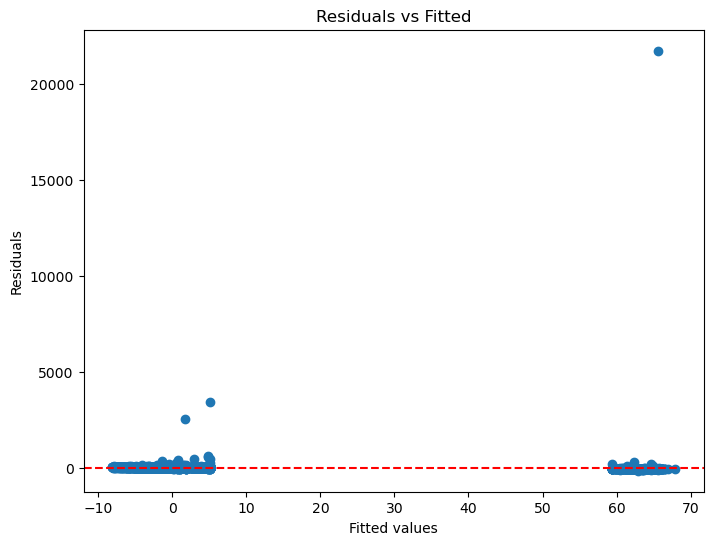

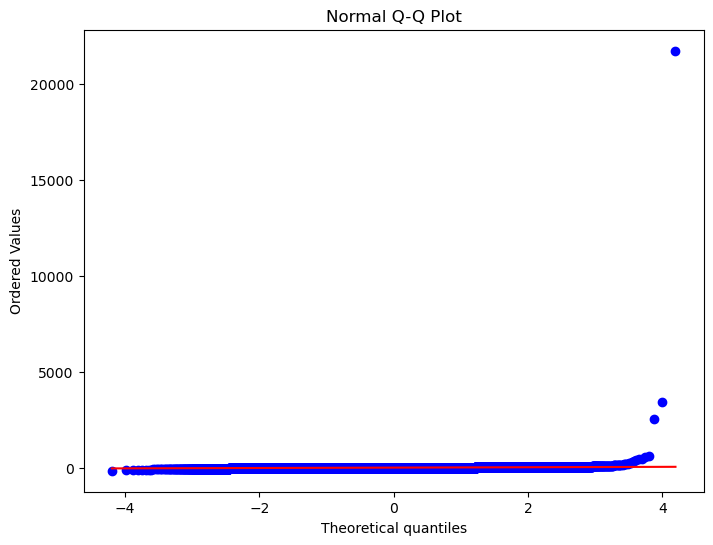

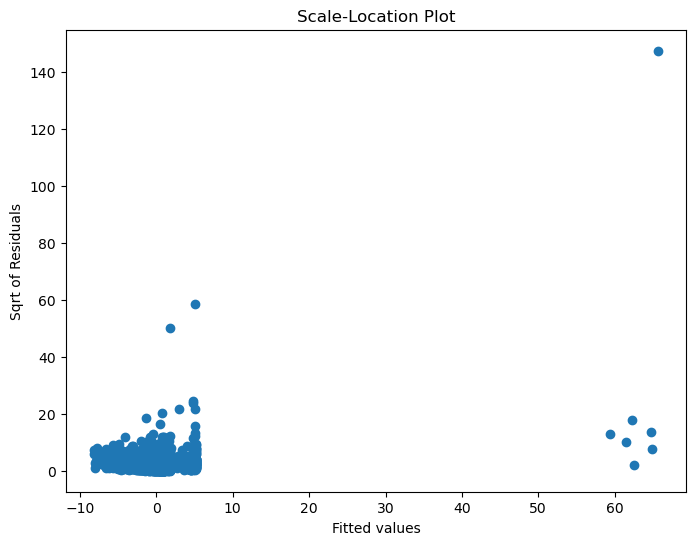

In [22]:
# Diangostic plots for the scaled model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals vs Fitted plot for checking linearity
plt.figure(figsize=(8,6))
plt.scatter(model_scaled.fittedvalues, model_scaled.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Normal Q-Q plot for checking normality of residuals
plt.figure(figsize=(8,6))
stats.probplot(model_scaled.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# Scale-Location plot for checking homoscedasticity
plt.figure(figsize=(8,6))
plt.scatter(model_scaled.fittedvalues, model_scaled.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

In [25]:
df['log_return'] = np.log(df['return'] + 1)
df['log_name_price_attention'] = np.log(df['name_price_attention'] + 1)

/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


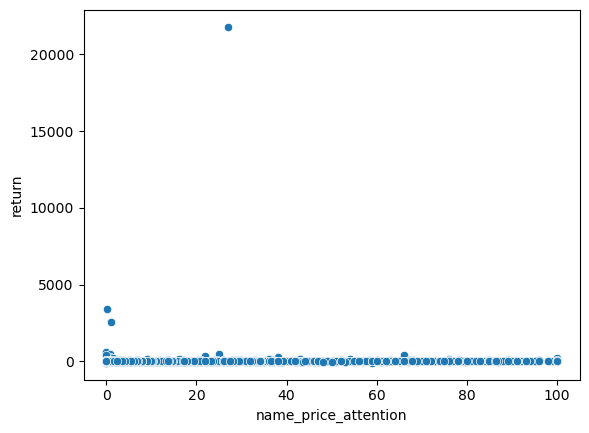

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot name_price_attention against return
sns.scatterplot(x='name_price_attention', y='return', data=df)
plt.show()

- Plot shows no clear linear pattern between the independent and dependent variable.


## Non-transformed OLS Regression with robust covariance type

In [11]:
#X1 = df[['name_price_attention']]
#X2 = df[['name_price_attention', 'mkt_cap', 'volume, volatility']]
#X3 = df[['name_price_attention', 'daily_volatility']]
#X4 = df[['name_price_attention', 'volume']]
#X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
#X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
#X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
#X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]
#X8 = df[['name_price_attention', 'mkt_cap', 'volume', ]]

In [29]:
from statsmodels.formula.api import ols

# Fit the model
model_1 = ols('Q("return") ~ name_price_attention + C(crypto_dummy) ', data=df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()  # solving the heteroskedasticity issue of non robust model 

# Print the summary
robust_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.526
Date:                Wed, 06 Mar 2024   Prob (F-statistic):             0.0394
Time:                        13:30:19   Log-Likelihood:            -3.1699e+05
No. Observations:               52892   AIC:                         6.340e+05
Df Residuals:                   52864   BIC:                         6.343e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9949      1.320      0.754      0.451      -1.592       3.581
C(crypto_dummy)[T.1]      2.1099      2.531      0.834      0.404      -2.850       7.070
C(crypto_dummy)[T.2]      0.5159      0.403      1.281      0.200      -0.274       1.305
C(crypto_dummy)[T.3]      0.9151      1.436      0.637      0.524      -1.899       3.729
C(crypto_dummy)[T.4]     -0.0416      0.393     -0.106      0.916      -0.812       0.729
C(crypto_dummy)[T.5]     -0.5128      0.968     -0.530      0.596      -2.411       1.385
C(crypto_dummy)[T.6]     -0.1827      0.659     -0.277      0.782      -1.474       1.109
C(crypto_dummy)[T.7]      0.1673      0.339      0.493      0.622      -0.497       0.832
C(crypto_dummy)[T.8]     -0.0120      0.418     -0.029      0.977      -0.831       0.807
C(crypto_dummy)[T.9]     -0.4558      1.170     -0.390      0.697      -2.748       1.837
C(crypto_dummy)[T.10]    -0.5208      1.177     -0.442      0.658      -2.828       1.787
C(crypto_dummy)[T.11]    -0.4116      1.054     -0.391      0.696      -2.477       1.654
C(crypto_dummy)[T.12]    -0.4692      0.882     -0.532      0.595      -2.197       1.259
C(crypto_dummy)[T.13]    54.3416     54.472      0.998      0.318     -52.424     161.107
C(crypto_dummy)[T.14]    -0.0413      0.852     -0.049      0.961      -1.711       1.628
C(crypto_dummy)[T.15]    -0.5913      1.031     -0.573      0.566      -2.613       1.430
C(crypto_dummy)[T.16]    -0.3574      0.910     -0.393      0.695      -2.142       1.427
C(crypto_dummy)[T.17]     0.3291      0.344      0.956      0.339      -0.345       1.004
C(crypto_dummy)[T.18]     0.0383      0.727      0.053      0.958      -1.387       1.463
C(crypto_dummy)[T.19]    -0.1981      0.627     -0.316      0.752      -1.427       1.030
C(crypto_dummy)[T.20]     4.0694      2.883      1.411      0.158      -1.582       9.721
C(crypto_dummy)[T.21]     0.4940      0.263      1.879      0.060      -0.021       1.009
C(crypto_dummy)[T.22]     0.0337      0.427      0.079      0.937      -0.804       0.872
C(crypto_dummy)[T.23]    -0.2701      1.009     -0.268      0.789      -2.247       1.707
C(crypto_dummy)[T.24]    -0.6759      1.094     -0.618      0.537      -2.821       1.469
C(crypto_dummy)[T.25]    -0.0523      0.429     -0.122      0.903      -0.893       0.789
C(crypto_dummy)[T.26]    -0.3199      0.649     -0.493      0.622      -1.593       0.953
name_price_attention     -0.0856      0.124     -0.689      0.491      -0.329       0.158
==============================================================================
Omnibus:                   264036.234   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5065301169657.728
Skew:                         214.708   Prob(JB):       

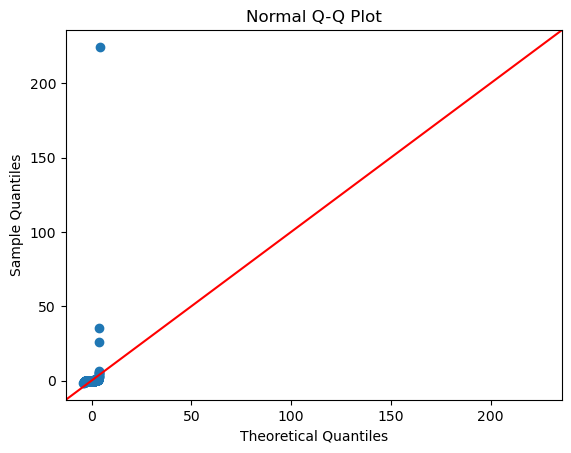

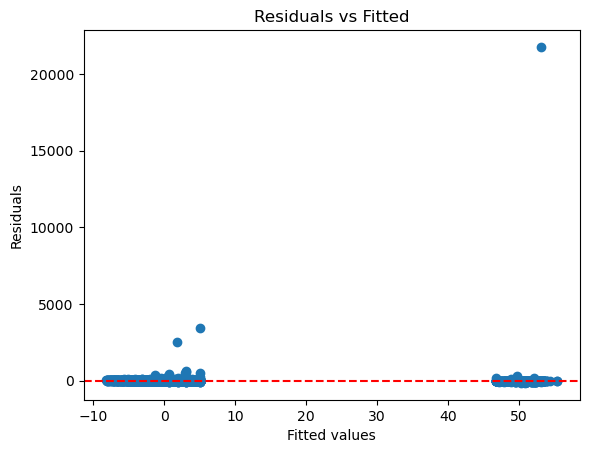

/var/folders/hp/hkpqf03x0qdg7_8s3s9sy7gw0000gn/T/ipykernel_14393/2702070619.py:15: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(robust_model_1.fittedvalues, robust_model_1.resid**0.5)


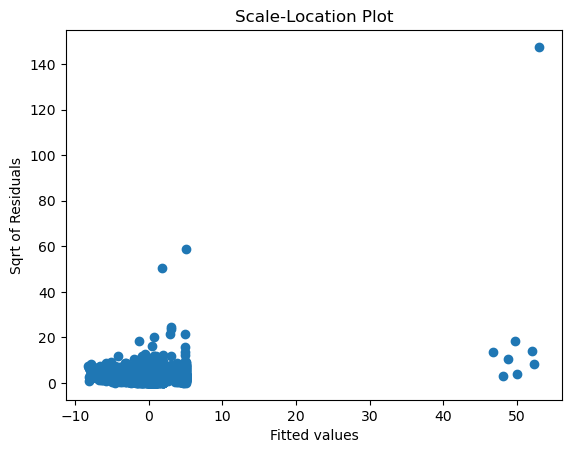

In [31]:
# QQ plot for normality of residuals
fig = sm.qqplot(robust_model_1.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(robust_model_1.fittedvalues, robust_model_1.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(robust_model_1.fittedvalues, robust_model_1.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
#sm.graphics.influence_plot(model_1, criterion="cooks")
#plt.title('Influence Plot')
#plt.show()

## OLS Regression with log X AND/OR Y

In [32]:
df['log_return'] = np.log(df['return'] + 1)
df['log_name_price_attention'] = np.log(df['name_price_attention'] + 1)

/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Exponential OLS Regression with Log_return, robust variance 

Normalization of Skewness: Financial returns are often not symmetrically distributed and can have heavy tails or skewness. Taking the logarithm of returns helps in normalizing the data, making it more symmetric and easier to model with statistical and econometric techniques.

Percentage Changes: The log of returns translates absolute price changes into relative, percentage changes, which are easier to compare across different assets or time periods. This is because the logarithmic function is a monotonic transformation, meaning it preserves the order of the data while scaling differences in a relative manner.

In [33]:
from statsmodels.formula.api import ols

# Fit the model
model_log = ols('Q("log_return") ~ name_price_attention + C(crypto_dummy) ', data=df).fit()

# Get robust covariance results
model_log = model_log.get_robustcov_results()

# Print the summary
model_log.summary()

/Users/alex/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal

### Logrithmic OLS Regression with robust variance

Dealing with Scaling Issues: Attention scores, particularly those scaled from 0 to 100, can suffer from scaling issues where changes at different levels of the scale are not directly comparable. For example, an increase from 10 to 20 might not have the same practical significance as an increase from 80 to 90, even though both are increases of 10 points. Taking the logarithm helps mitigate this issue by transforming the scale into one where changes are more uniformly interpretable.

Diminishing Returns to Attention: The concept of diminishing returns might apply to attention as well. The difference in impact between an attention score of 90 and 100 is likely less significant than the difference between 10 and 20, even though both represent a 10-point increase. The logarithmic scale naturally reflects diminishing sensitivity as attention scores increase.

Linearizing Exponential Relationships: If the underlying relationship between attention and some outcome of interest (like sales, popularity, etc.) is exponential, taking the logarithm of attention can help linearize this relationship, making it easier to model with linear regression techniques. This is often the case in situations where a little bit of attention can lead to a large increase in the outcome, but additional attention yields progressively smaller increases.

In [16]:
from statsmodels.formula.api import ols

# Fit the model
model_1 = ols('Q("return") ~ log_name_price_attention + C(stock_dummy) ', data=df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.161
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.254
Time:                        12:26:22   Log-Likelihood:             1.8544e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70419   BIC:                        -3.706e+05
Df Model:                          28                                         
Covariance Type:                  HC1                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0004      0.000      0.875      0.381      -0.000       0.001
C(stock_dummy)[T.1]         -0.0003      0.000     -0.526      0.599      -0.001       0.001
C(stock_dummy)[T.2]         -0.0001      0.001     -0.271      0.786      -0.001       0.001
C(stock_dummy)[T.3]         -0.0002      0.001     -0.363      0.717      -0.001       0.001
C(stock_dummy)[T.4]         -0.0002      0.001     -0.448      0.654      -0.001       0.001
C(stock_dummy)[T.5]          0.0001      0.001      0.212      0.832      -0.001       0.001
C(stock_dummy)[T.6]         -0.0004      0.000     -0.935      0.350      -0.001       0.000
C(stock_dummy)[T.7]         -0.0006      0.001     -1.193      0.233      -0.002       0.000
C(stock_dummy)[T.8]         -0.0007      0.000     -1.347      0.178      -0.002       0.000
C(stock_dummy)[T.9]         -0.0001      0.001     -0.272      0.785      -0.001       0.001
C(stock_dummy)[T.10]        -0.0003      0.000     -0.692      0.489      -0.001       0.001
C(stock_dummy)[T.11]        -0.0003      0.000     -0.659      0.510      -0.001       0.001
C(stock_dummy)[T.12]        -0.0010      0.000     -2.177      0.029      -0.002      -0.000
C(stock_dummy)[T.13]        -0.0005      0.001     -0.949      0.342      -0.002       0.001
C(stock_dummy)[T.14]        -0.0003      0.000     -0.588      0.556      -0.001       0.001
C(stock_dummy)[T.15]     -5.341e-05      0.001     -0.105      0.916      -0.001       0.001
C(stock_dummy)[T.16]        -0.0003      0.000     -0.600      0.548      -0.001       0.001
C(stock_dummy)[T.17]        -0.0002      0.000     -0.520      0.603      -0.001       0.001
C(stock_dummy)[T.18]        -0.0007      0.000     -1.590      0.112      -0.002       0.000
C(stock_dummy)[T.19]        -0.0004      0.000     -0.783      0.434      -0.001       0.001
C(stock_dummy)[T.20]         0.0001      0.000      0.233      0.816      -0.001       0.001
C(stock_dummy)[T.21]     -2.701e-05      0.001     -0.052      0.959      -0.001       0.001
C(stock_dummy)[T.22]        -0.0003      0.000     -0.649      0.516      -0.001       0.001
C(stock_dummy)[T.23]     -6.214e-05      0.000     -0.128      0.898      -0.001       0.001
C(stock_dummy)[T.24]         0.0009      0.001      1.133      0.257      -0.001       0.002
C(stock_dummy)[T.25]         0.0006      0.001      1.108      0.268      -0.000       0.002
C(stock_dummy)[T.26]        -0.0010      0.000     -2.331      0.020      -0.002      -0.000
C(stock_dummy)[T.27]        -0.0006      0.000     -1.373      0.170      -0.001       0.000
log_name_price_attention     0.0003   6.96e-05      3.692      0.000       0.000       0.000
==============================================================================
Omnibus:                    

### Power OLS Model with Log Return and Log X, robust variance

In [17]:
from statsmodels.formula.api import ols

# Fit the model
model_1 = ols('Q("log_return") ~ log_name_price_attention + C(stock_dummy) ', data=df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8179
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.738
Time:                        12:26:23   Log-Likelihood:             1.8539e+05
No. Observations:               70448   AIC:                        -3.707e+05
Df Residuals:                   70419   BIC:                        -3.705e+05
Df Model:                          28                                         
Covariance Type:                  HC1                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0004      0.000      1.016      0.310      -0.000       0.001
C(stock_dummy)[T.1]         -0.0003      0.000     -0.601      0.548      -0.001       0.001
C(stock_dummy)[T.2]         -0.0003      0.001     -0.542      0.588      -0.001       0.001
C(stock_dummy)[T.3]         -0.0004      0.001     -0.715      0.474      -0.002       0.001
C(stock_dummy)[T.4]         -0.0003      0.001     -0.541      0.589      -0.001       0.001
C(stock_dummy)[T.5]      -6.276e-05      0.001     -0.109      0.913      -0.001       0.001
C(stock_dummy)[T.6]         -0.0004      0.000     -0.915      0.360      -0.001       0.000
C(stock_dummy)[T.7]         -0.0007      0.001     -1.263      0.207      -0.002       0.000
C(stock_dummy)[T.8]         -0.0007      0.000     -1.431      0.152      -0.002       0.000
C(stock_dummy)[T.9]         -0.0003      0.001     -0.502      0.615      -0.001       0.001
C(stock_dummy)[T.10]        -0.0003      0.000     -0.601      0.548      -0.001       0.001
C(stock_dummy)[T.11]        -0.0003      0.000     -0.701      0.483      -0.001       0.001
C(stock_dummy)[T.12]        -0.0009      0.000     -1.978      0.048      -0.002   -8.29e-06
C(stock_dummy)[T.13]        -0.0006      0.001     -1.046      0.296      -0.002       0.000
C(stock_dummy)[T.14]        -0.0003      0.000     -0.674      0.500      -0.001       0.001
C(stock_dummy)[T.15]        -0.0001      0.001     -0.287      0.774      -0.001       0.001
C(stock_dummy)[T.16]        -0.0003      0.000     -0.716      0.474      -0.001       0.001
C(stock_dummy)[T.17]        -0.0002      0.000     -0.501      0.616      -0.001       0.001
C(stock_dummy)[T.18]        -0.0008      0.000     -1.616      0.106      -0.002       0.000
C(stock_dummy)[T.19]        -0.0003      0.000     -0.767      0.443      -0.001       0.001
C(stock_dummy)[T.20]         0.0001      0.000      0.207      0.836      -0.001       0.001
C(stock_dummy)[T.21]        -0.0002      0.001     -0.316      0.752      -0.001       0.001
C(stock_dummy)[T.22]        -0.0003      0.000     -0.703      0.482      -0.001       0.001
C(stock_dummy)[T.23]        -0.0002      0.000     -0.345      0.730      -0.001       0.001
C(stock_dummy)[T.24]         0.0004      0.001      0.517      0.605      -0.001       0.002
C(stock_dummy)[T.25]         0.0004      0.001      0.770      0.441      -0.001       0.001
C(stock_dummy)[T.26]        -0.0009      0.000     -2.091      0.037      -0.002   -5.61e-05
C(stock_dummy)[T.27]        -0.0005      0.000     -1.242      0.214      -0.001       0.000
log_name_price_attention     0.0002   6.96e-05      2.638      0.008    4.72e-05       0.000
==============================================================================
Omnibus:                    

In summary, this model appears to have issues with the normality of residuals, explanatory power, and overall significance, indicating that it might need to be re-specified with different variables, transformations, or perhaps a different modeling approach altogether.

In [18]:
anomalies_df.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,...,name_price_attention,stock_dummy,revenue,total_assets,earnings_per_share,book_to_market,dt_date,jan_dummy,monday_dummy,annual_rep_release
0,2014-01-02,10107,MSFT,37.16,30423757.0,-0.006683,37.40,37.10,37.350,37.25,...,3.15,20,NaN,NaN,NaN,NaN,2014-01-02,1,0,0
1,2014-01-03,10107,MSFT,36.91,30944370.0,-0.006728,37.22,36.60,37.200,36.91,...,1.54,20,NaN,NaN,NaN,NaN,2014-01-03,1,0,0
2,2014-01-06,10107,MSFT,36.13,43111355.0,-0.021133,36.89,36.11,36.850,36.50,...,2.24,20,NaN,NaN,NaN,NaN,2014-01-06,1,1,0
3,2014-01-07,10107,MSFT,36.41,35478667.0,0.007750,36.49,36.21,36.325,36.35,...,1.19,20,NaN,NaN,NaN,NaN,2014-01-07,1,0,0
4,2014-01-08,10107,MSFT,35.76,59452427.0,-0.017852,36.14,35.58,36.000,35.86,...,1.68,20,NaN,NaN,NaN,NaN,2014-01-08,1,0,0


In [19]:
# Fit the model
model_1 = ols('Q("return") ~ name_price_attention + C(stock_dummy) + mkt_cap + volume + C(jan_dummy) + C(monday_dummy) + C(annual_rep_release)', data=anomalies_df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

/Users/christel/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.056
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.382
Time:                        12:26:23   Log-Likelihood:             1.8546e+05
No. Observations:               70448   AIC:                        -3.709e+05
Df Residuals:                   70414   BIC:                        -3.705e+05
Df Model:                          33                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0015      0.001      2.185      0.029       0.000       0.003
C(stock_dummy)[T.1]           -0.0013      0.001     -1.826      0.068      -0.003    9.68e-05
C(stock_dummy)[T.2]           -0.0011      0.001     -1.473      0.141      -0.003       0.000
C(stock_dummy)[T.3]           -0.0009      0.001     -1.153      0.249      -0.002       0.001
C(stock_dummy)[T.4]           -0.0012      0.001     -1.586      0.113      -0.003       0.000
C(stock_dummy)[T.5]           -0.0008      0.001     -0.979      0.327      -0.002       0.001
C(stock_dummy)[T.6]           -0.0007      0.001     -1.177      0.239      -0.002       0.000
C(stock_dummy)[T.7]           -0.0014      0.001     -2.032      0.042      -0.003   -5.04e-05
C(stock_dummy)[T.8]           -0.0013      0.001     -1.877      0.061      -0.003    5.72e-05
C(stock_dummy)[T.9]           -0.0011      0.001     -1.534      0.125      -0.003       0.000
C(stock_dummy)[T.10]          -0.0014      0.001     -1.935      0.053      -0.003    1.74e-05
C(stock_dummy)[T.11]          -0.0013      0.001     -1.815      0.070      -0.003       0.000
C(stock_dummy)[T.12]          -0.0022      0.001     -2.895      0.004      -0.004      -0.001
C(stock_dummy)[T.13]          -0.0007      0.001     -1.038      0.299      -0.002       0.001
C(stock_dummy)[T.14]          -0.0013      0.001     -1.995      0.046      -0.002   -2.22e-05
C(stock_dummy)[T.15]          -0.0008      0.001     -1.257      0.209      -0.002       0.000
C(stock_dummy)[T.16]          -0.0009      0.001     -1.562      0.118      -0.002       0.000
C(stock_dummy)[T.17]          -0.0011      0.001     -1.672      0.094      -0.002       0.000
C(stock_dummy)[T.18]          -0.0016      0.001     -2.259      0.024      -0.003      -0.000
C(stock_dummy)[T.19]          -0.0010      0.001     -1.558      0.119      -0.002       0.000
C(stock_dummy)[T.20]          -0.0005      0.001     -0.939      0.348      -0.002       0.001
C(stock_dummy)[T.21]          -0.0007      0.001     -1.039      0.299      -0.002       0.001
C(stock_dummy)[T.22]          -0.0013      0.001     -1.984      0.047      -0.002   -1.51e-05
C(stock_dummy)[T.23]          -0.0011      0.001     -1.556      0.120      -0.003       0.000
C(stock_dummy)[T.24]           0.0006      0.001      0.714      0.475      -0.001       0.002
C(stock_dummy)[T.25]          -0.0005      0.001     -0.778      0.436      -0.002       0.001
C(stock_dummy)[T.26]          -0.0016      0.001     -2.527      0.012      -0.003      -0.000
C(stock_dummy)[T.27]          -0.0015      0.001     -2.204      0.027      -0.003      -0.000
C(jan_dummy)[T.1]             -0.0004      0.000     -1.576      0.115      -0.001    9.24e-05
C(monday_dummy)[T.1]           0.0002      

not provide a good fit to the data. The tests indicate that the residuals are not normally distributed and that the model explains an insignificant portion of the variance in returns. The very high condition number is particularly concerning as it suggests that multicollinearity is likely influencing the regression estimates, which might mean that the regression coefficients are unstable and unreliable. This could also mean that the model is overfitted, with too many predictors and not enough signal.

In [20]:
# check if there is mulitcollinearity between the independent variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = anomalies_df[['name_price_attention', 'stock_dummy' ,  'mkt_cap' , 'volume' , 'jan_dummy' , 'monday_dummy',  'annual_rep_release']]

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()

# Create a column in the dataframe that will contain the names of all the feature variables
vif["Features"] = X.columns

# Create a column in the dataframe that will contain the VIF values of the feature variables
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the dataframe
print(vif)

               Features       VIF
0  name_price_attention  1.870184
1           stock_dummy  1.702969
2               mkt_cap  2.119586
3                volume  2.237787
4             jan_dummy  1.070516
5          monday_dummy  1.172346
6    annual_rep_release  1.009481


Since all values are < 3 we can conclude that there is no multicolinarity present between our independent variables. 

In [21]:
anomalies_df['log_return'] = np.log(anomalies_df['return'] + 1)
# Fit the model
model_1 = ols('Q("log_return") ~ name_price_attention + C(stock_dummy) + mkt_cap + volume + C(jan_dummy) + C(monday_dummy) + C(annual_rep_release)', data=anomalies_df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

/Users/christel/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.8551
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.697
Time:                        12:26:24   Log-Likelihood:             1.8543e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70414   BIC:                        -3.705e+05
Df Model:                          33                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0016      0.001      2.406      0.016       0.000       0.003
C(stock_dummy)[T.1]           -0.0014      0.001     -1.990      0.047      -0.003   -2.18e-05
C(stock_dummy)[T.2]           -0.0013      0.001     -1.801      0.072      -0.003       0.000
C(stock_dummy)[T.3]           -0.0012      0.001     -1.555      0.120      -0.003       0.000
C(stock_dummy)[T.4]           -0.0013      0.001     -1.736      0.083      -0.003       0.000
C(stock_dummy)[T.5]           -0.0010      0.001     -1.338      0.181      -0.003       0.000
C(stock_dummy)[T.6]           -0.0007      0.001     -1.044      0.296      -0.002       0.001
C(stock_dummy)[T.7]           -0.0016      0.001     -2.227      0.026      -0.003      -0.000
C(stock_dummy)[T.8]           -0.0014      0.001     -2.106      0.035      -0.003      -0.000
C(stock_dummy)[T.9]           -0.0013      0.001     -1.840      0.066      -0.003    8.74e-05
C(stock_dummy)[T.10]          -0.0014      0.001     -2.020      0.043      -0.003   -4.27e-05
C(stock_dummy)[T.11]          -0.0014      0.001     -1.998      0.046      -0.003   -2.69e-05
C(stock_dummy)[T.12]          -0.0021      0.001     -2.775      0.006      -0.004      -0.001
C(stock_dummy)[T.13]          -0.0006      0.001     -0.848      0.397      -0.002       0.001
C(stock_dummy)[T.14]          -0.0014      0.001     -2.267      0.023      -0.003      -0.000
C(stock_dummy)[T.15]          -0.0009      0.001     -1.485      0.137      -0.002       0.000
C(stock_dummy)[T.16]          -0.0010      0.001     -1.693      0.090      -0.002       0.000
C(stock_dummy)[T.17]          -0.0013      0.001     -1.840      0.066      -0.003     8.2e-05
C(stock_dummy)[T.18]          -0.0018      0.001     -2.473      0.013      -0.003      -0.000
C(stock_dummy)[T.19]          -0.0011      0.001     -1.694      0.090      -0.002       0.000
C(stock_dummy)[T.20]          -0.0007      0.001     -1.251      0.211      -0.002       0.000
C(stock_dummy)[T.21]          -0.0010      0.001     -1.389      0.165      -0.002       0.000
C(stock_dummy)[T.22]          -0.0014      0.001     -2.155      0.031      -0.003      -0.000
C(stock_dummy)[T.23]          -0.0013      0.001     -1.818      0.069      -0.003       0.000
C(stock_dummy)[T.24]           0.0003      0.001      0.298      0.766      -0.001       0.002
C(stock_dummy)[T.25]          -0.0009      0.001     -1.223      0.221      -0.002       0.001
C(stock_dummy)[T.26]          -0.0015      0.001     -2.295      0.022      -0.003      -0.000
C(stock_dummy)[T.27]          -0.0015      0.001     -2.318      0.020      -0.003      -0.000
C(jan_dummy)[T.1]             -0.0004      0.000     -1.515      0.130      -0.001       0.000
C(monday_dummy)[T.1]           0.0001      

Switching to log returns has not materially changed the output of your regression model. The model's explanatory power is still very low, and the statistical tests indicate that the assumptions for an ideal OLS model, such as normal distribution of residuals, are not met. The presence of high kurtosis and a high condition number suggests that there may be outliers affecting the model and issues with multicollinearity, respectively.

In [22]:
anomalies_df['log_name_price_attention'] = np.log(anomalies_df['name_price_attention'] + 1)

# Fit the model
model_1 = ols('Q("log_return") ~ log_name_price_attention + C(stock_dummy) + mkt_cap + volume + C(jan_dummy) + C(monday_dummy) + C(annual_rep_release)', data=anomalies_df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

/Users/christel/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("log_return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.028
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.423
Time:                        12:26:25   Log-Likelihood:             1.8543e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70414   BIC:                        -3.705e+05
Df Model:                          33                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0011      0.001      1.665      0.096      -0.000       0.002
C(stock_dummy)[T.1]           -0.0011      0.001     -1.509      0.131      -0.002       0.000
C(stock_dummy)[T.2]           -0.0010      0.001     -1.319      0.187      -0.002       0.000
C(stock_dummy)[T.3]           -0.0010      0.001     -1.265      0.206      -0.003       0.001
C(stock_dummy)[T.4]           -0.0010      0.001     -1.338      0.181      -0.002       0.000
C(stock_dummy)[T.5]           -0.0007      0.001     -0.925      0.355      -0.002       0.001
C(stock_dummy)[T.6]           -0.0004      0.001     -0.717      0.474      -0.002       0.001
C(stock_dummy)[T.7]           -0.0013      0.001     -1.916      0.055      -0.003    3.09e-05
C(stock_dummy)[T.8]           -0.0013      0.001     -1.877      0.061      -0.003    5.72e-05
C(stock_dummy)[T.9]           -0.0010      0.001     -1.354      0.176      -0.002       0.000
C(stock_dummy)[T.10]          -0.0011      0.001     -1.651      0.099      -0.003       0.000
C(stock_dummy)[T.11]          -0.0011      0.001     -1.569      0.117      -0.002       0.000
C(stock_dummy)[T.12]          -0.0017      0.001     -2.429      0.015      -0.003      -0.000
C(stock_dummy)[T.13]          -0.0003      0.001     -0.456      0.648      -0.002       0.001
C(stock_dummy)[T.14]          -0.0011      0.001     -1.732      0.083      -0.002       0.000
C(stock_dummy)[T.15]          -0.0006      0.001     -1.003      0.316      -0.002       0.001
C(stock_dummy)[T.16]          -0.0007      0.001     -1.140      0.254      -0.002       0.000
C(stock_dummy)[T.17]          -0.0010      0.001     -1.453      0.146      -0.002       0.000
C(stock_dummy)[T.18]          -0.0015      0.001     -2.160      0.031      -0.003      -0.000
C(stock_dummy)[T.19]          -0.0009      0.001     -1.400      0.162      -0.002       0.000
C(stock_dummy)[T.20]          -0.0006      0.001     -1.090      0.276      -0.002       0.000
C(stock_dummy)[T.21]          -0.0007      0.001     -1.032      0.302      -0.002       0.001
C(stock_dummy)[T.22]          -0.0010      0.001     -1.589      0.112      -0.002       0.000
C(stock_dummy)[T.23]          -0.0009      0.001     -1.225      0.221      -0.002       0.001
C(stock_dummy)[T.24]           0.0005      0.001      0.593      0.553      -0.001       0.002
C(stock_dummy)[T.25]          -0.0005      0.001     -0.633      0.527      -0.002       0.001
C(stock_dummy)[T.26]          -0.0012      0.001     -2.007      0.045      -0.002   -2.78e-05
C(stock_dummy)[T.27]          -0.0013      0.001     -2.057      0.040      -0.003   -6.33e-05
C(jan_dummy)[T.1]             -0.0004      0.000     -1.554      0.120      -0.001    9.78e-05
C(monday_dummy)[T.1]           0.0001      

The changes made by logging attention do not seem to have had a significant impact on the overall fit and quality of the regression model. The model still lacks explanatory power, the residuals do not meet the assumption of normality, and multicollinearity remains a concern.

In [23]:
# Fit the model
model_1 = ols('Q("return") ~ log_name_price_attention + C(stock_dummy) + mkt_cap + volume + C(jan_dummy) + C(monday_dummy) + C(annual_rep_release)', data=anomalies_df).fit()

# Get robust covariance results
robust_model_1 = model_1.get_robustcov_results()

# Print the summary
robust_model_1.summary()

/Users/christel/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.274
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.141
Time:                        12:26:25   Log-Likelihood:             1.8546e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70414   BIC:                        -3.705e+05
Df Model:                          33                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0008      0.001      1.190      0.234      -0.001       0.002
C(stock_dummy)[T.1]           -0.0008      0.001     -1.067      0.286      -0.002       0.001
C(stock_dummy)[T.2]           -0.0006      0.001     -0.781      0.435      -0.002       0.001
C(stock_dummy)[T.3]           -0.0006      0.001     -0.717      0.473      -0.002       0.001
C(stock_dummy)[T.4]           -0.0007      0.001     -0.919      0.358      -0.002       0.001
C(stock_dummy)[T.5]           -0.0003      0.001     -0.369      0.712      -0.002       0.001
C(stock_dummy)[T.6]           -0.0004      0.001     -0.622      0.534      -0.002       0.001
C(stock_dummy)[T.7]           -0.0011      0.001     -1.510      0.131      -0.002       0.000
C(stock_dummy)[T.8]           -0.0010      0.001     -1.496      0.135      -0.002       0.000
C(stock_dummy)[T.9]           -0.0006      0.001     -0.830      0.406      -0.002       0.001
C(stock_dummy)[T.10]          -0.0009      0.001     -1.288      0.198      -0.002       0.000
C(stock_dummy)[T.11]          -0.0008      0.001     -1.147      0.251      -0.002       0.001
C(stock_dummy)[T.12]          -0.0015      0.001     -2.163      0.031      -0.003      -0.000
C(stock_dummy)[T.13]          -0.0002      0.001     -0.383      0.702      -0.002       0.001
C(stock_dummy)[T.14]          -0.0008      0.001     -1.251      0.211      -0.002       0.000
C(stock_dummy)[T.15]          -0.0004      0.001     -0.565      0.572      -0.002       0.001
C(stock_dummy)[T.16]          -0.0005      0.001     -0.788      0.431      -0.002       0.001
C(stock_dummy)[T.17]          -0.0007      0.001     -1.065      0.287      -0.002       0.001
C(stock_dummy)[T.18]          -0.0012      0.001     -1.751      0.080      -0.003       0.000
C(stock_dummy)[T.19]          -0.0007      0.001     -1.079      0.281      -0.002       0.001
C(stock_dummy)[T.20]          -0.0004      0.001     -0.704      0.482      -0.001       0.001
C(stock_dummy)[T.21]          -0.0004      0.001     -0.531      0.596      -0.002       0.001
C(stock_dummy)[T.22]          -0.0007      0.001     -1.164      0.244      -0.002       0.001
C(stock_dummy)[T.23]          -0.0005      0.001     -0.717      0.474      -0.002       0.001
C(stock_dummy)[T.24]           0.0010      0.001      1.179      0.238      -0.001       0.003
C(stock_dummy)[T.25]        1.591e-07      0.001      0.000      1.000      -0.001       0.001
C(stock_dummy)[T.26]          -0.0011      0.001     -1.939      0.053      -0.002    1.24e-05
C(stock_dummy)[T.27]          -0.0011      0.001     -1.732      0.083      -0.002       0.000
C(jan_dummy)[T.1]             -0.0004      0.000     -1.635      0.102      -0.001    7.83e-05
C(monday_dummy)[T.1]           0.0002      

Removing the anomalies January effect, Monday effect and Annual report Release to reduce multicolinarity. 

In [24]:
print(anomalies_df.columns)

Index(['date', 'permno', 'ticker', 'price', 'volume', 'return', 'high', 'low',
       'open', 'avg_price', 'mkt_cap', 'pct_return', 'name_price_attention',
       'stock_dummy', 'revenue', 'total_assets', 'earnings_per_share',
       'book_to_market', 'dt_date', 'jan_dummy', 'monday_dummy',
       'annual_rep_release', 'log_return', 'log_name_price_attention'],
      dtype='object')


In [25]:
# Fit the model
model_all = ols('Q("return") ~ C(stock_dummy) + name_price_attention ', data=anomalies_df).fit()

# Get robust covariance results
model_all = model_all.get_robustcov_results()

# Print the summary
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("return")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.8891
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.634
Time:                        12:26:26   Log-Likelihood:             1.8544e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70419   BIC:                        -3.706e+05
Df Model:                          28                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0006      0.000      1.462      0.144      -0.000       0.001
C(stock_dummy)[T.1]     -0.0004      0.000     -0.775      0.438      -0.001       0.001
C(stock_dummy)[T.2]     -0.0002      0.001     -0.451      0.652      -0.001       0.001
C(stock_dummy)[T.3]     -0.0002      0.001     -0.295      0.768      -0.001       0.001
C(stock_dummy)[T.4]     -0.0003      0.001     -0.569      0.569      -0.001       0.001
C(stock_dummy)[T.5]   4.916e-05      0.001      0.085      0.932      -0.001       0.001
C(stock_dummy)[T.6]     -0.0005      0.000     -0.981      0.327      -0.001       0.000
C(stock_dummy)[T.7]     -0.0006      0.001     -1.132      0.258      -0.002       0.000
C(stock_dummy)[T.8]     -0.0006      0.001     -1.142      0.253      -0.002       0.000
C(stock_dummy)[T.9]     -0.0002      0.001     -0.456      0.649      -0.001       0.001
C(stock_dummy)[T.10]    -0.0004      0.000     -0.764      0.445      -0.001       0.001
C(stock_dummy)[T.11]    -0.0004      0.000     -0.758      0.449      -0.001       0.001
C(stock_dummy)[T.12]    -0.0012      0.000     -2.452      0.014      -0.002      -0.000
C(stock_dummy)[T.13]    -0.0006      0.001     -1.156      0.248      -0.002       0.000
C(stock_dummy)[T.14]    -0.0004      0.000     -0.858      0.391      -0.001       0.000
C(stock_dummy)[T.15]    -0.0002      0.001     -0.332      0.740      -0.001       0.001
C(stock_dummy)[T.16]    -0.0004      0.000     -0.903      0.367      -0.001       0.000
C(stock_dummy)[T.17]    -0.0002      0.000     -0.533      0.594      -0.001       0.001
C(stock_dummy)[T.18]    -0.0007      0.000     -1.472      0.141      -0.002       0.000
C(stock_dummy)[T.19]    -0.0003      0.000     -0.679      0.497      -0.001       0.001
C(stock_dummy)[T.20]     0.0001      0.000      0.238      0.812      -0.001       0.001
C(stock_dummy)[T.21] -3.835e-05      0.001     -0.072      0.943      -0.001       0.001
C(stock_dummy)[T.22]    -0.0004      0.000     -0.992      0.321      -0.001       0.000
C(stock_dummy)[T.23]    -0.0002      0.000     -0.488      0.625      -0.001       0.001
C(stock_dummy)[T.24]     0.0008      0.001      1.022      0.307      -0.001       0.002
C(stock_dummy)[T.25]     0.0004      0.001      0.709      0.478      -0.001       0.001
C(stock_dummy)[T.26]    -0.0011      0.000     -2.448      0.014      -0.002      -0.000
C(stock_dummy)[T.27]    -0.0006      0.000     -1.253      0.210      -0.001       0.000
name_price_attention   2.36e-05   9.94e-06      2.374      0.018    4.12e-06    4.31e-05
==============================================================================
Omnibus:                    15704.034   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           767936.50

# Using Hubert T norm to deal with the outliers. 

In [34]:
import statsmodels.formula.api as smf
formula = 'Q("return") ~ C(stock_dummy) + log_name_price_attention'

model = smf.rlm(formula, data=anomalies_df, M=sm.robust.norms.HuberT())
results = model.fit()

# Print the summary
print(results.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:            Q("return")   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70419
Method:                          IRLS   Df Model:                           28
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        12:27:53                                         
No. Iterations:                    28                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The robust regression shows that attention does have a statistically significant influence on the dependent variable but it seems to be very small. 

In [36]:
formula = 'Q("return") ~ C(stock_dummy) + name_price_attention'

model = smf.rlm(formula, data=anomalies_df, M=sm.robust.norms.HuberT())
results = model.fit()

# Print the summary
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            Q("return")   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70419
Method:                          IRLS   Df Model:                           28
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        12:29:27                                         
No. Iterations:                    28                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0007 

In [27]:
formula = 'Q("return") ~ log_name_price_attention + C(stock_dummy) + mkt_cap + volume + C(jan_dummy) + C(monday_dummy) + C(annual_rep_release)'

model = smf.rlm(formula, data=anomalies_df, M=sm.robust.norms.HuberT())
results = model.fit()

# Print the summary
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            Q("return")   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70414
Method:                          IRLS   Df Model:                           33
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2024                                         
Time:                        12:26:34                                         
No. Iterations:                    50                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The output of the model shows that including the other variables increased the influence of attention on return whilst the p-value indicated that this influence is still statisticaly significant. 

<Axes: xlabel='name_price_attention', ylabel='log_return'>

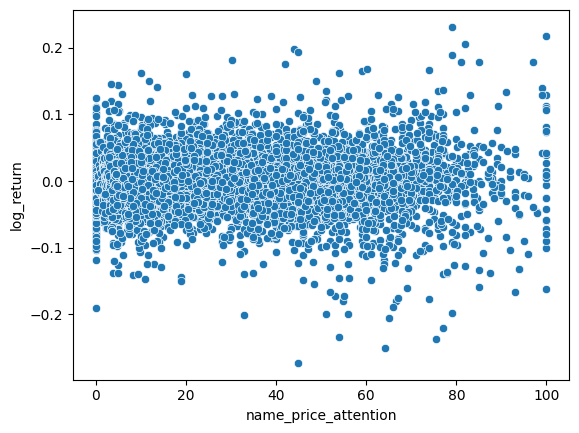

In [28]:
## plot log returns agains name_price_attention
import numpy as np

# Calculate log returns
df['log_return'] = np.log(df['return'] + 1)

# Plot name_price_attention against log_return
sns.scatterplot(x='name_price_attention', y='log_return', data=df)

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.574
Date:                Wed, 06 Mar 2024   Prob (F-statistic):             0.0521
Time:                        12:26:34   Log-Likelihood:             1.8538e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70444   BIC:                        -3.707e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

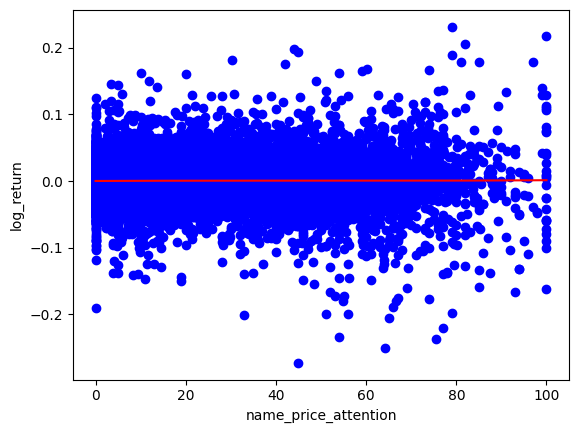

In [29]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame 'df' with 'name_price_attention' and 'log_return'

# Generate polynomial features
df['name_price_attention_squared'] = df['name_price_attention'] ** 2
df['name_price_attention_cubed'] = df['name_price_attention'] ** 3

# Define the independent variables (including polynomial terms) and the dependent variable
X = df[['name_price_attention', 'name_price_attention_squared', 'name_price_attention_cubed']]
y = df['log_return']

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Fit the polynomial regression model
model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())

# Plot the results
plt.scatter(df['name_price_attention'], y, color='blue')  # Plot the raw data
plt.xlabel('name_price_attention')
plt.ylabel('log_return')

# Prepare the data for plotting the fitted line
# Sorting the DataFrame by 'name_price_attention' so the line plot is ordered
df_sorted = df.sort_values(by='name_price_attention')

# Plot the fitted values
plt.plot(df_sorted['name_price_attention'], model.predict(sm.add_constant(df_sorted[['name_price_attention', 'name_price_attention_squared', 'name_price_attention_cubed']])), color='red')
plt.show()


In [30]:
import pandas as pd
from scipy import stats
from scipy.special import inv_boxcox
import numpy as np
import statsmodels.api as sm

# Load your data
# df = pd.read_csv('your_data.csv')  # If you have a CSV file

# I'm assuming the DataFrame from your screenshot is loaded into 'df'
# And assuming log returns are already calculated in the 'return' column

# Apply the Box-Cox transformation to a shifted version of 'name_price_attention' to make it positive
# Shift the data if there are non-positive values
df['name_price_attention_shifted'] = df['name_price_attention'] + abs(df['name_price_attention'].min()) + 1

# Apply the Box-Cox transformation
df['name_price_attention_transformed'], fitted_lambda = stats.boxcox(df['name_price_attention_shifted'])

# Fit the linear regression model
X = sm.add_constant(df['name_price_attention_transformed'])  # Adds a constant term to the predictor
model = sm.OLS(df['return'], X).fit()

# Print out the statistics
print(model.summary())

# Transform back to original scale if needed for interpretation
df['name_price_attention_back'] = inv_boxcox(df['name_price_attention_transformed'], fitted_lambda) - abs(df['name_price_attention'].min()) - 1


                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     15.19
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           9.74e-05
Time:                        12:26:34   Log-Likelihood:             1.8542e+05
No. Observations:               70448   AIC:                        -3.708e+05
Df Residuals:                   70446   BIC:                        -3.708e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [31]:
from statsmodels.formula.api import ols

# Fit the model
model_all = ols('Q("return") ~ C(stock_dummy) + name_price_attention + volatility + mkt_cap ', data=df).fit()

# Get robust covariance results
model_all = model_all.get_robustcov_results()

# Print the summary
model_all.summary()

PatsyError: Error evaluating factor: NameError: name 'volatility' is not defined
    Q("return") ~ C(stock_dummy) + name_price_attention + volatility + mkt_cap
                                                          ^^^^^^^^^^

In [ ]:
# splitting the data 
fix_seed = 42

y = df['return']
X = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
#X3 = df[['name_price_attention', 'daily_volatility']]
#X4 = df[['name_price_attention', 'volume']]
#X5 = df[['name_price_attention', 'mkt_cap']]
#X6 = df[['name_price_attention', 'mkt_cap']]
#X7 = df[['name_price_attention', 'mkt_cap']]
#X8 = df[['name_price_attention', 'mkt_cap']]
#X9 = df[['name_price_attention', 'mkt_cap']]
#X10 = df[['name_price_attention', 'mkt_cap']]
#X11 =  df[['name_price_attention', 'mkt_cap']]






X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

In [ ]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.661
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00325
Time:                        17:22:02   Log-Likelihood:                -79957.
No. Observations:               56358   AIC:                         1.599e+05
Df Residuals:                   56356   BIC:                         1.599e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0031 

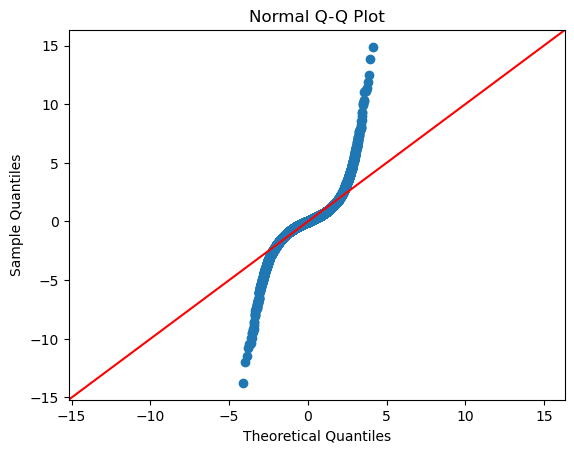

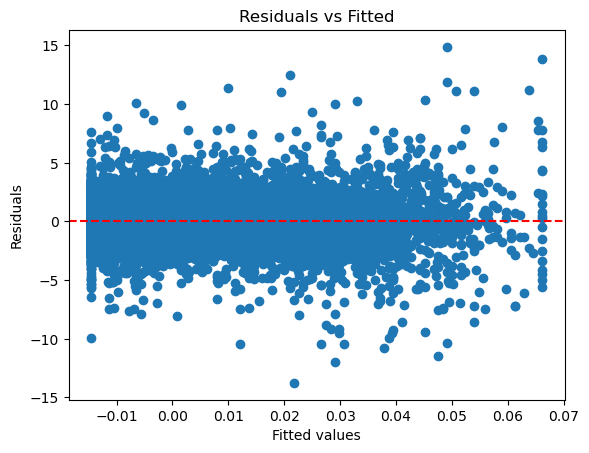

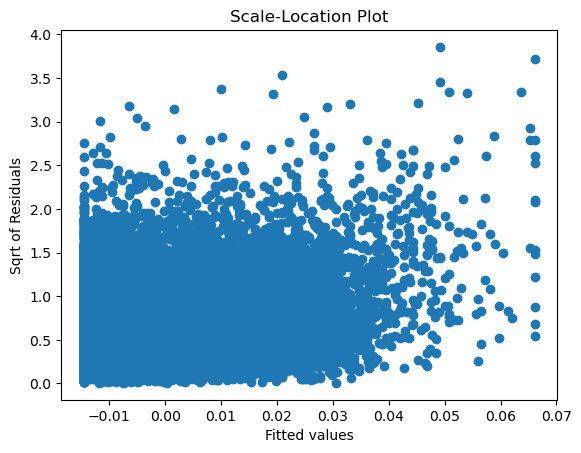

KeyboardInterrupt: 

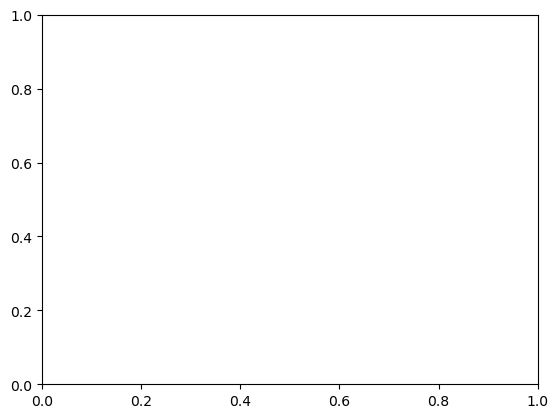

In [ ]:
# QQ plot for normality of residuals
fig = sm.qqplot(results.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
sm.graphics.influence_plot(results, criterion="cooks")
plt.title('Influence Plot')
plt.show()

Given these results we will use a robust regression which does not have these assumptions. 

In [ ]:
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]

X6 = sm.add_constant(X6)  
model = sm.OLS(y, X6)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.63
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           3.71e-10
Time:                        17:36:55   Log-Likelihood:                -99938.
No. Observations:               70448   AIC:                         1.999e+05
Df Residuals:                   70444   BIC:                         1.999e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.144e-18 

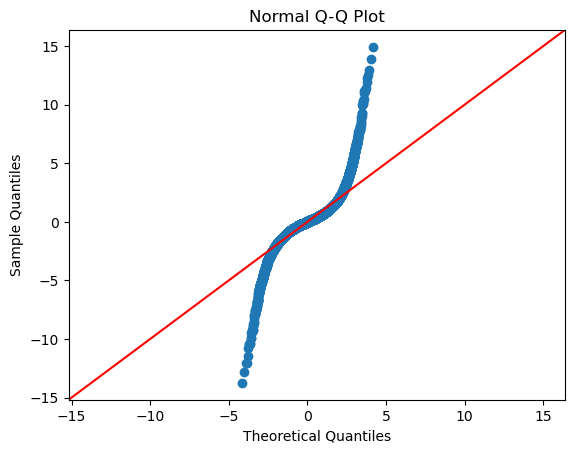

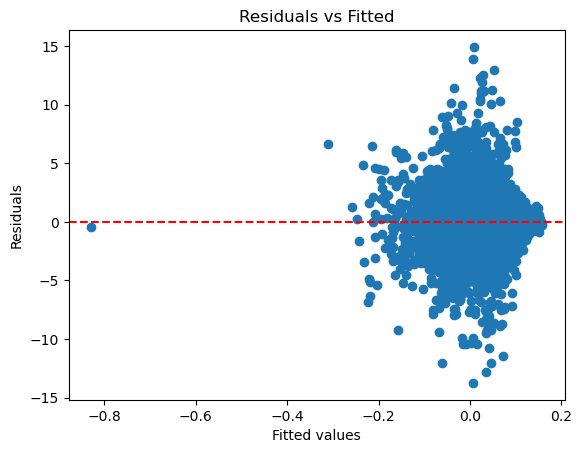

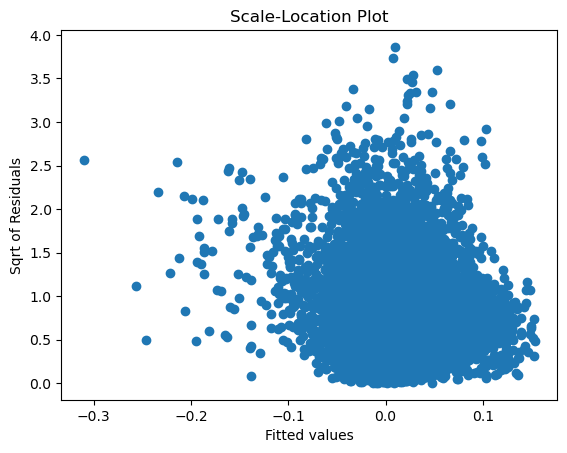

KeyboardInterrupt: 

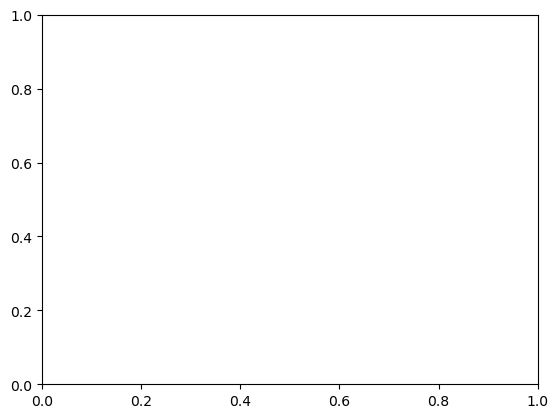

In [ ]:
# QQ plot for normality of residuals
fig = sm.qqplot(results.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
sm.graphics.influence_plot(results, criterion="cooks")
plt.title('Influence Plot')
plt.show()

In [ ]:
# create numpy arrays for each feature combination to later call in the OLS and robust regression 
X1 = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
#X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
#X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
#X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
#X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]
#X8 = df[['name_price_attention', 'mkt_cap', 'volume', ]]

In [ ]:
# create a robust regression for each feature combination
X1 = sm.add_constant(X1)
model1 = sm.RLM(y, X1, M=sm.robust.norms.HuberT())
results1 = model1.fit()
print(results1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70446
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        17:26:24                                         
No. Iterations:                    21                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0039 

In [ ]:
X2 = sm.add_constant(X2)
model2 = sm.RLM(y, X2, M=sm.robust.norms.HuberT())
results2 = model.fit()
print(results2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:26                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X3 = sm.add_constant(X3)
model3 = sm.RLM(y, X3, M=sm.robust.norms.HuberT())
results3 = model.fit()
print(results3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:27                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X4 = sm.add_constant(X4)
model4 = sm.RLM(y, X4, M=sm.robust.norms.HuberT())
results4 = model.fit()
print(results4.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:27                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X5 = sm.add_constant(X5)
model5 = sm.RLM(y, X5, M=sm.robust.norms.HuberT())
results5 = model.fit()
print(results5.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:28                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X6 = sm.add_constant(X6)
model6 = sm.RLM(y, X6, M=sm.robust.norms.HuberT())
results6 = model.fit()
print(results6.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:28                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X7 = sm.add_constant(X7)
model7 = sm.RLM(y, X7, M=sm.robust.norms.HuberT())
results7 = model.fit()
print(results7.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:29                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X8 = sm.add_constant(X8)
model8 = sm.RLM(y, X8, M=sm.robust.norms.HuberT())
results8 = model.fit()
print(results8.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        15:51:29                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
# print a regression table showing all the results 
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[results,results,results,results,results,results,results,results],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8'],
                            info_dict=info_dict,
                            regressor_order=['const','name_price_attention', 'mkt_cap', 'daily_volatility', 'volume'])

results_table.add_title('Table 1 - OLS and Robust Regression Results')
print(results_table)

                        Table 1 - OLS and Robust Regression Results
                     Model 1  Model 2  Model 3  Model 4  Model 5  Model 6  Model 7  Model 8 
--------------------------------------------------------------------------------------------
const                0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
name_price_attention 0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
mkt_cap              0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
daily_volatility     0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00***  0.00*** 
                     (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)   (0.00)  
vo

In [ ]:
# Create a summary table
from statsmodels.iolib.summary2 import summary_col

# You can customize the summary table further as needed
results_table = summary_col(models,
                             stars=True,
                             model_names=[
                                 'Model1', 'Model2', 'Model3',
                                 'Model4', 'Model5', 'Model6',
                                 'Model7', 'Model8'
                             ],
                             info_dict={
                                 'R2': lambda x: f"{x.rsquared:.2f}",
                                 'No. observations': lambda x: f"{int(x.nobs)}"
                             })

print(results_table)



NameError: name 'models' is not defined